# Data exploration and preprocessing

## Library imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fontTools.misc.cython import returns
from openpyxl.styles.builtins import normal
from pandas.core.common import random_state
from setuptools.command.rotate import rotate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import label_binarize
from scipy.special import expit  # Sigmoid function


from scipy.stats import chi2_contingency

import time

from IPython.display import display, Markdown

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

## Data imports

In [2]:
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

C:\Users\afons\AppData\Local\Temp\ipykernel_46052\94885567.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('train_data.csv')


## Quick data overview

First, we will take a quick look at the data to understand its structure and the type of variables we are dealing with.

In [3]:
# in order to display all columns
pd.set_option('display.max_columns', None)

# Display titles with DataFrames
display(Markdown("### Train DataFrame"))
display(train_df.head())

display(Markdown("### Test DataFrame"))
display(test_df.head())

### Train DataFrame

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,NaN,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


### Test DataFrame

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents
0,2022-12-24,19,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,6165911,BRONX,N,NYC,NaN,M,NaN,48.0,TRANSPORTATION AND WAREHOUSING,IV,NaN,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,54.0,LOWER LEG,10466,1
1,2022-11-20,19,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,A I U INSURANCE COMPANY,1A. PRIVATE,6166141,QUEENS,N,NYC,NaN,F,NaN,45.0,RETAIL TRADE,IV,NaN,75.0,FALLING OR FLYING OBJECT,10.0,CONTUSION,10.0,MULTIPLE HEAD INJURY,11691,1
2,2022-12-26,59,N,2023-01-02,N,0.0,1963.0,2022-12-31,NaN,AMGUARD INSURANCE COMPANY,1A. PRIVATE,6165907,WESTCHESTER,N,NYC,NaN,F,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,III,NaN,68.0,STATIONARY OBJECT,49.0,SPRAIN OR TEAR,62.0,BUTTOCKS,10604,0
3,2022-12-28,55,N,2023-01-02,N,0.0,0.0,2023-01-02,NaN,INDEMNITY INS. OF N AMERICA,1A. PRIVATE,6166047,QUEENS,N,NYC,NaN,F,NaN,48.0,TRANSPORTATION AND WAREHOUSING,IV,NaN,25.0,FROM DIFFERENT LEVEL (ELEVATION),10.0,CONTUSION,53.0,KNEE,11411,6
4,2022-12-20,25,N,2023-01-02,N,0.0,1997.0,2022-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,6166102,KINGS,N,NYC,NaN,M,NaN,55.0,MANAGEMENT OF COMPANIES AND ENTERPRISES,IV,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,40.0,LACERATION,37.0,THUMB,11212,5


* Datatypes and missing values

In [4]:
display(Markdown("### Train DataFrame"))
display(train_df.info())

display(Markdown("### Test DataFrame"))
display(test_df.info())

### Train DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

None

### Test DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387975 entries, 0 to 387974
Data columns (total 30 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       385531 non-null  object 
 1   Age at Injury                       387975 non-null  int64  
 2   Alternative Dispute Resolution      387975 non-null  object 
 3   Assembly Date                       387975 non-null  object 
 4   Attorney/Representative             387975 non-null  object 
 5   Average Weekly Wage                 368771 non-null  float64
 6   Birth Year                          368505 non-null  float64
 7   C-2 Date                            378841 non-null  object 
 8   C-3 Date                            85216 non-null   object 
 9   Carrier Name                        387975 non-null  object 
 10  Carrier Type                        387975 non-null  object 
 11  Claim Identifier          

None

The column “OIICS Nature of Injury Description" contains only Nan values, having no variability and failing to provide any information to the model,  therefore, it can be safely dropped. Dropping it will make the dataset cleaner and reduce complexity. Also, the target variable 'Claim Injury Type' has some missing values that will be explored further in the next sections.

## Duplicate values

In [5]:
display(Markdown("### Train DataFrame"))
display(f"{train_df.duplicated().sum()} duplicated rows")

display(Markdown("### Test DataFrame"))
display(f"{test_df.duplicated().sum()} duplicated rows")

# Get the repeated Claim Identifier in the training dataset

if train_df[train_df['Claim Identifier'].duplicated()].shape[0] > 0:
    print(f" \nList of duplicate ids in Training dataset: {train_df[train_df['Claim Identifier'].duplicated()]['Claim Identifier'].values.tolist()}")

if test_df[test_df['Claim Identifier'].duplicated()].shape[0] > 0:
    print(f" \nList of duplicate ids in Test dataset: {test_df[test_df['Claim Identifier'].duplicated()]['Claim Identifier'].values.tolist()}")

### Train DataFrame

'0 duplicated rows'

### Test DataFrame

'0 duplicated rows'

 
List of duplicate ids in Training dataset: [292668076]


There are no duplicate rows in both datasets, although there is a repeated 'Claim Identifier' in the training dataset.

In [6]:
train_df[train_df['Claim Identifier'] == 292668076]

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
257901,NaN,NaN,NaN,2021-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292668076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526445,NaN,NaN,NaN,2022-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292668076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Descriptive statistics

* For numerical variables

In [7]:
display(Markdown("### Train DataFrame"))
display(train_df.describe())

display(Markdown("### Test DataFrame"))
display(test_df.describe())

### Train DataFrame

,Age at Injury,Average Weekly Wage,Birth Year,Claim Identifier,IME-4 Count,Industry Code,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
count,574026.000000,5.453750e+05,544948.000000,5.934710e+05,132803.000000,564068.000000,0.0,558386.000000,558369.000000,556944.000000,574026.000000,574026.000000
mean,42.114270,4.910883e+02,1886.767604,2.366760e+07,3.207337,58.645305,NaN,54.381143,41.013839,39.738146,0.046665,3.006559
std,14.256432,6.092918e+03,414.644423,1.079271e+08,2.832303,19.644175,NaN,25.874281,22.207521,22.365940,0.210921,2.000801
min,0.000000,0.000000e+00,0.000000,5.393066e+06,1.000000,11.000000,NaN,1.000000,1.000000,-9.000000,0.000000,0.000000
25%,31.000000,0.000000e+00,1965.000000,5.593414e+06,1.000000,45.000000,NaN,31.000000,16.000000,33.000000,0.000000,1.000000
50%,42.000000,0.000000e+00,1977.000000,5.791212e+06,2.000000,61.000000,NaN,56.000000,49.000000,38.000000,0.000000,3.000000
75%,54.000000,8.410000e+02,1989.000000,5.991000e+06,4.000000,71.000000,NaN,75.000000,52.000000,53.000000,0.000000,5.000000
max,117.000000,2.828079e+06,2018.000000,9.998917e+08,73.000000,92.000000,NaN,99.000000,91.000000,99.000000,1.000000,6.000000


### Test DataFrame

,Age at Injury,Average Weekly Wage,Birth Year,Claim Identifier,IME-4 Count,Industry Code,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents
count,387975.000000,3.687710e+05,368505.000000,3.879750e+05,35249.000000,380239.000000,0.0,377627.000000,377415.000000,378426.000000,387975.000000
mean,41.414944,1.833438e+02,1875.383466,6.359878e+06,2.118131,58.653581,NaN,53.335678,38.373674,31.516109,3.000284
std,14.501056,3.542310e+03,444.659075,1.121062e+05,1.465406,18.710501,NaN,26.176833,20.966100,23.359950,1.997982
min,0.000000,0.000000e+00,0.000000,6.165686e+06,1.000000,11.000000,NaN,1.000000,1.000000,-9.000000,0.000000
25%,30.000000,0.000000e+00,1967.000000,6.262798e+06,1.000000,45.000000,NaN,29.000000,10.000000,15.000000,1.000000
50%,40.000000,0.000000e+00,1980.000000,6.359876e+06,2.000000,61.000000,NaN,56.000000,43.000000,36.000000,3.000000
75%,53.000000,0.000000e+00,1992.000000,6.456966e+06,2.000000,71.000000,NaN,74.000000,52.000000,51.000000,5.000000
max,114.000000,1.950317e+06,2019.000000,6.554041e+06,18.000000,92.000000,NaN,99.000000,91.000000,99.000000,6.000000


There are some inconsistencies in the data, for example the minimum value for 'Age at Injury', 'Birth Year' and 'Average Weekly Wage' is 0. Also, the 'WCIO Part Of Body Code' minimum value is -9 which does not match with any of the available codes in https://www.wcio.org/Active%20PNC/WCIO_Part_Table.pdf. We will look at the description in those rows to understand the issue later in the data cleaning section.

* For categorical variables

In [8]:
display(Markdown("### Train DataFrame"))
display(train_df.describe(include='object').T)

display(Markdown("### Test DataFrame"))
display(test_df.describe(include='object').T)

### Train DataFrame

,count,unique,top,freq
Accident Date,570337,5539,2020-03-01,1245
Alternative Dispute Resolution,574026,3,N,571412
Assembly Date,593471,1096,2020-03-06,1422
Attorney/Representative,574026,2,N,392291
C-2 Date,559466,2475,2021-05-11,1847
C-3 Date,187245,1648,2021-04-21,350
Carrier Name,574026,2046,STATE INSURANCE FUND,111144
Carrier Type,574026,8,1A. PRIVATE,285368
Claim Injury Type,574026,8,2. NON-COMP,291078
County of Injury,574026,63,SUFFOLK,60430


### Test DataFrame

,count,unique,top,freq
Accident Date,385531,3438,2024-01-16,1263
Alternative Dispute Resolution,387975,3,N,386314
Assembly Date,387975,434,2023-09-21,1789
Attorney/Representative,387975,2,N,306476
C-2 Date,378841,1048,2023-10-11,1687
C-3 Date,85216,626,2023-10-04,341
Carrier Name,387975,1598,STATE INSURANCE FUND,66189
Carrier Type,387975,7,1A. PRIVATE,201827
County of Injury,387975,63,QUEENS,40358
COVID-19 Indicator,387975,2,N,385434


In the training dataset, 'WCB Decision' has only one unique value, therefore it does not provide any useful information. This column will be dropped in data cleaning section.

* For target variable

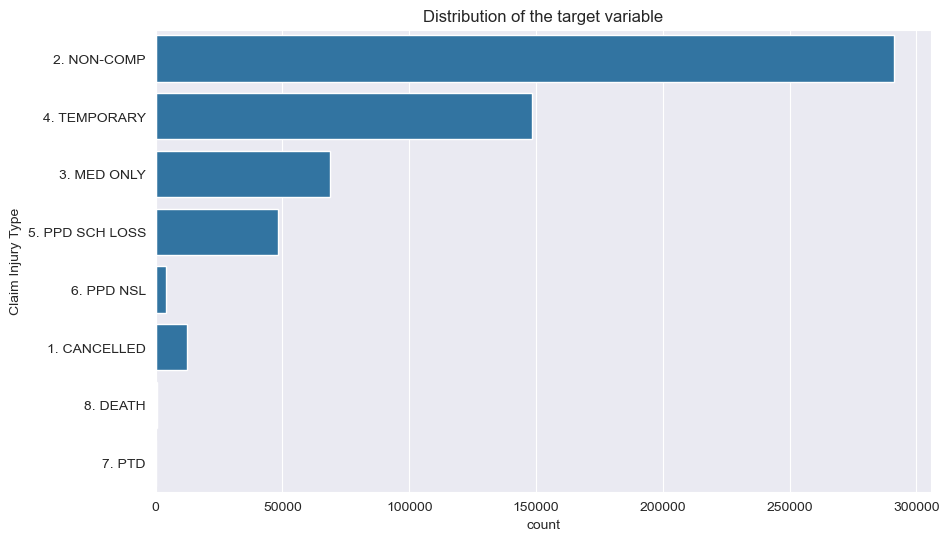

In [9]:
# Ploting the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(train_df['Claim Injury Type'])
plt.title('Distribution of the target variable')
plt.show()

The target variable is imbalanced, with the majority of the claims being of class '2. NON-COMP' or '4. TEMPORARY'.

* Exploring training dataset when 'Claim Injury Type' is missing

In [10]:
train_df[train_df['Claim Injury Type'].isna()].head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,363651794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209507552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,970865999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,807753247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It looks like the only information we have is the "Claim Identifier" and "Assembly Date". Let's see if the assumption is correct.

In [11]:
# Checking if there is no information besides 'Claim Identifier' and 'Assembly Date' in these rows
pd.DataFrame(train_df[train_df['Claim Injury Type'].isna()].notna().sum(), columns=['Not NaN values Count'])

,Not NaN values Count
Accident Date,0
Age at Injury,0
Alternative Dispute Resolution,0
Assembly Date,19445
Attorney/Representative,0
Average Weekly Wage,0
Birth Year,0
C-2 Date,0
C-3 Date,0
Carrier Name,0


The 'Claim Identifier' and 'Assembly Date' are not only the only columns with information, but they also don't have any missing values in the given subset. There is no way we can use this information to predict the target variable, therefore these rows will be dropped in the next section.

## Data cleaning

* Dropping unnecessary columns

In [12]:
train_df.drop(columns=['OIICS Nature of Injury Description'], inplace=True)
test_df.drop(columns=['OIICS Nature of Injury Description'], inplace=True)

train_df.drop(columns=['WCB Decision'], inplace=True)

* Dropping unnecessary rows

In [13]:
train_df.dropna(subset=["Claim Injury Type"], inplace=True)

In this part we drop the rows with missing values in the target variable and the duplicated 'Claim Identifier' as it was included in those rows.

* Incoherent values correction

In [14]:
# Changing 0 values in 'Birth Year' to NaN
train_df.loc[train_df["Birth Year"] == 0, "Birth Year"] = np.nan
test_df.loc[test_df["Birth Year"] == 0, "Birth Year"] = np.nan

# Changing 0 values in 'Age at Injury' to NaN
train_df.loc[train_df["Age at Injury"] == 0, "Age at Injury"] = np.nan
test_df.loc[test_df["Age at Injury"] == 0, "Age at Injury"] = np.nan

# dropping rows where Accident Date is greater than Assembly Date
train_df = train_df[train_df['Accident Date'] <= train_df['Assembly Date']]
test_df = test_df[test_df['Accident Date'] <= test_df['Assembly Date']]


# Check the 'WCIO Part Of Body Description' when 'WCIO Part Of Body Code' is -9
display(Markdown("### Train DataFrame"))
print(train_df[train_df['WCIO Part Of Body Code'] == -9]['WCIO Part Of Body Description'].value_counts())

display(Markdown("### Test DataFrame"))
print(test_df[test_df['WCIO Part Of Body Code'] == -9]['WCIO Part Of Body Description'].value_counts())

### Train DataFrame

WCIO Part Of Body Description
MULTIPLE    41631
Name: count, dtype: int64


### Test DataFrame

WCIO Part Of Body Description
MULTIPLE    67084
Name: count, dtype: int64


The description for 'WCIO Part Of Body Code' -9 is 'MULTIPLE', So we can assume that they are codes related to the 'Multiple Body Parts' section, so either 64, 65, 66, 90, 21 or 99. We will replace the -9 values with the most common code within those 6. This will be done after the train-validation split to prevent data leakage.

* Dropping columns with high cardinality

In [15]:
train_df.drop(columns=['Zip Code', 'Carrier Name'], inplace=True)
test_df.drop(columns=['Zip Code', 'Carrier Name'], inplace=True)

* Correcting dtypes

In [16]:
# Selecting columns with 'date' in the name
date_columns = [col for col in train_df.columns if 'date' in col.lower()]

# Convert columns to datetime
for col in date_columns:
    train_df[col] = pd.to_datetime(train_df[col], errors="coerce")
    test_df[col] = pd.to_datetime(test_df[col], errors="coerce")


# creating a list for code columns
code_columns = [col for col in train_df.columns if 'code' in col.lower()]

# Converting code columns to string
for col in code_columns:
    train_df[col] = train_df[col].astype('str')
    test_df[col] = test_df[col].astype('str')


# Converting 'Agreement Reached' to categorical
train_df['Agreement Reached'] = train_df['Agreement Reached'].astype('str')

display(Markdown("### Train DataFrame"))
print(train_df.dtypes)

display(Markdown("### Test DataFrame"))
print(test_df.dtypes)

### Train DataFrame

Accident Date                        datetime64[ns]
Age at Injury                               float64
Alternative Dispute Resolution               object
Assembly Date                        datetime64[ns]
Attorney/Representative                      object
Average Weekly Wage                         float64
Birth Year                                  float64
C-2 Date                             datetime64[ns]
C-3 Date                             datetime64[ns]
Carrier Type                                 object
Claim Identifier                              int64
Claim Injury Type                            object
County of Injury                             object
COVID-19 Indicator                           object
District Name                                object
First Hearing Date                   datetime64[ns]
Gender                                       object
IME-4 Count                                 float64
Industry Code                                object
Industry Cod

### Test DataFrame

Accident Date                        datetime64[ns]
Age at Injury                               float64
Alternative Dispute Resolution               object
Assembly Date                        datetime64[ns]
Attorney/Representative                      object
Average Weekly Wage                         float64
Birth Year                                  float64
C-2 Date                             datetime64[ns]
C-3 Date                             datetime64[ns]
Carrier Type                                 object
Claim Identifier                              int64
County of Injury                             object
COVID-19 Indicator                           object
District Name                                object
First Hearing Date                   datetime64[ns]
Gender                                       object
IME-4 Count                                 float64
Industry Code                                object
Industry Code Description                    object
Medical Fee 

* Imputing missing values on Birth Year and Age at Injury with the help of Accident Date year

In [17]:
# Printing missing values before imputation
display(Markdown("### Missing values before imputation"))
print(pd.DataFrame([train_df[["Birth Year", "Age at Injury"]].isna().sum(), test_df[["Birth Year", "Age at Injury"]].isna().sum()], index=['Train Dataset', 'Test Dataset']))

# Impute Birth Year using Accident Date and Age at Injury
train_df.loc[train_df["Birth Year"].isna(), "Birth Year"] = (
    train_df["Accident Date"].dt.year - train_df["Age at Injury"]
)
test_df.loc[test_df["Birth Year"].isna(), "Birth Year"] = (
    test_df["Accident Date"].dt.year - test_df["Age at Injury"]
)


# Impute Age at Injury using Accident Date and Birth Year
train_df.loc[train_df["Age at Injury"].isna(), "Age at Injury"] = (
    train_df["Accident Date"].dt.year - train_df["Birth Year"]
)
test_df.loc[test_df["Age at Injury"].isna(), "Age at Injury"] = (
    test_df["Accident Date"].dt.year - test_df["Birth Year"]
)

# Printing missing values after imputation in train and test datasets
display(Markdown("### Missing values after imputation"))
print(pd.DataFrame([train_df[["Birth Year", "Age at Injury"]].isna().sum(), test_df[["Birth Year", "Age at Injury"]].isna().sum()], index=['Train Dataset', 'Test Dataset']))

### Missing values before imputation

               Birth Year  Age at Injury
Train Dataset       53520           1775
Test Dataset        38718            804


### Missing values after imputation

               Birth Year  Age at Injury
Train Dataset        1682           1682
Test Dataset          647            647


## Preprocessing

* Mapping the target variable to numerical values

In [18]:
# Map each category of 'Claim Injury Type' to a numeric value, accordingly to the numeric prefix of the category
injury_type_mapping = {
    '2. NON-COMP': 2,
    '4. TEMPORARY': 4,
    '3. MED ONLY': 3,
    '5. PPD SCH LOSS': 5,
    '6. PPD NSL': 6,
    '1. CANCELLED': 1,
    '8. DEATH': 8,
    '7. PTD': 7,
}


# Remove possible blank spaces next to the values
train_df["Claim Injury Type"] = train_df["Claim Injury Type"].str.strip()

# Apply the previous mapping to 'Claim Injury Type' column
train_df["Claim Injury Type"] = train_df["Claim Injury Type"].map(injury_type_mapping)

# Check unique values of the column after mapping
print(train_df["Claim Injury Type"].unique())

[2 4 3 5 6 1 8 7]


### Data splitting

Splitting the training data into training and validation sets

In [19]:
train_df.set_index('Claim Identifier', inplace=True)

In [20]:
X = train_df.drop('Claim Injury Type', axis = 1)
y = train_df['Claim Injury Type']

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3,
                                                  random_state = 42,
                                                  stratify = y,
                                                  shuffle = True)

* Replacing -9 values in 'WCIO Part Of Body Code' to the most common code in the 'Multiple Body Parts' section.

In [21]:
# Get the most common code in the 'Multiple Body Parts' section of the column 'WCIO Part Of Body Code'
most_common_code = (
    X_train[(X_train["WCIO Part Of Body Code"] == "64.0") |
            (X_train["WCIO Part Of Body Code"] == "65.0") |
            (X_train["WCIO Part Of Body Code"] == "66.0") |
            (X_train["WCIO Part Of Body Code"] == "90.0") |
            (X_train["WCIO Part Of Body Code"] == "91.0") |
            (X_train["WCIO Part Of Body Code"] == "99.0")]["WCIO Part Of Body Code"].mode()[0]
)

# Replace -9 values with the most common code
for df in [X_train, X_val, test_df]:
    df.loc[df["WCIO Part Of Body Code"] == "-9.0", "WCIO Part Of Body Code"] = most_common_code


* Separating numerical and categorical columns

In [22]:
numerical_col = X_train.select_dtypes(include=np.number).columns.tolist()

categorical_col = X_train.select_dtypes(exclude=np.number).columns.tolist()

# remove date columns from categorical columns
categorical_col = [col for col in categorical_col if col not in date_columns]

In [23]:
print(f"Numerical column names: {numerical_col}")
print(f"\nCategorical column names: {categorical_col}")

Numerical column names: ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents']

Categorical column names: ['Alternative Dispute Resolution', 'Attorney/Representative', 'Carrier Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender', 'Industry Code', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Agreement Reached']


### Feature engineering

* Mappings for new features

In [24]:
# Define the mapping dictionary for groups, using numeric equivalents instead of Roman numerals
wcio_cause_group_mapping = {'1.0': 1, '2.0': 1, '3.0': 1, '4.0': 1, '5.0': 1,
    '6.0': 1, '7.0': 1, '8.0': 1, '9.0': 1, '11.0': 1, '14.0': 1, '84.0': 1,
    '10.0': 2, '12.0': 2, '13.0': 2, '20.0': 2, '15.0': 3, '16.0': 3,
    '17.0': 3, '18.0': 3, '19.0': 3, '25.0': 4, '26.0': 4, '27.0': 4, '28.0': 4,
    '29.0': 4, '30.0': 4, '31.0': 4, '32.0': 4, '33.0': 4, '40.0': 5, '41.0': 5,
    '45.0': 5, '46.0': 5, '47.0': 5, '48.0': 5, '50.0': 5, '52.0': 6, '53.0': 6,
    '54.0': 6, '55.0': 6, '56.0': 6, '57.0': 6, '58.0': 6, '59.0': 6, '60.0': 6,
    '61.0': 6, '97.0': 6, '65.0': 7, '66.0': 7, '67.0': 7, '68.0': 7, '69.0': 7,
    '70.0': 7, '74.0': 8, '75.0': 8, '76.0': 8, '77.0': 8, '78.0': 8, '79.0': 8,
    '80.0': 8, '81.0': 8, '85.0': 8, '86.0': 8, '94.0': 9, '95.0': 9, '82.0': 10,
    '83.0': 10, '87.0': 10, '88.0': 10, '89.0': 10, '90.0': 10, '91.0': 10, '93.0': 10,
    '96.0': 10, '98.0': 10, '99.0': 10}


# Dicionário de mapeamento para grupos
nature_of_injury_mapping = {
     # Specific Injury
     '1.0': 1, '2.0': 1, '3.0': 1, '4.0': 1, '7.0': 1, '10.0': 1, '13.0': 1, '16.0': 1,
     '19.0': 1, '22.0': 1, '25.0': 1, '28.0': 1, '30.0': 1, '31.0': 1, '32.0': 1, '34.0': 1,
     '36.0': 1, '37.0': 1, '38.0': 1, '40.0': 1, '41.0': 1, '42.0': 1, '43.0': 1, '46.0': 1,
     '47.0': 1, '49.0': 1, '52.0': 1, '53.0': 1, '54.0': 1, '55.0': 1, '58.0': 1, '59.0': 1,
     # Occupational Disease or Cumulative Injury
     '60.0': 2, '61.0': 2, '62.0': 2, '63.0': 2, '64.0': 2, '65.0': 2, '66.0': 2, '67.0': 2,
     '68.0': 2, '69.0': 2, '70.0': 2, '71.0': 2, '72.0': 2, '73.0': 2, '74.0': 2, '75.0': 2,
     '76.0': 2, '77.0': 2, '78.0': 2, '79.0': 2, '80.0': 2, '83.0': 2,
     # Multiple Injuries
     '90.0': 3, '91.0': 3
}

# Dicionário de mapeamento para grupos
part_of_body_mapping = {
    # Head
    '10.0': 1, '11.0': 1, '12.0': 1, '13.0': 1, '14.0': 1, '15.0': 1, '16.0': 1, '17.0': 1,
     '18.0': 1, '19.0': 1,
    # Neck
     '20.0': 2, '21.0': 2, '22.0': 2, '23.0': 2, '24.0': 2, '25.0': 2, '26.0': 2,
    # Upper Extremities
     '30.0': 3, '31.0': 3, '32.0': 3, '33.0': 3, '34.0': 3, '35.0': 3, '36.0': 3, '37.0': 3,
     '38.0': 3, '39.0': 3,
    # Trunk
     '40.0': 4, '41.0': 4, '42.0': 4, '43.0': 4, '44.0': 4, '45.0': 4, '46.0': 4, '47.0': 4,
     '48.0': 4, '49.0': 4, '60.0': 4, '61.0': 4, '62.0': 4, '63.0': 4,
    # Lower Extremities
     '50.0': 5, '51.0': 5, '52.0': 5, '53.0': 5, '54.0': 5, '55.0': 5, '56.0': 5, '57.0': 5,
     '58.0': 5,
     # Multiple Body Parts
     '64.0': 6, '65.0': 6, '66.0': 6, '90.0': 6, '91.0': 6, '99.0': 6
}

# Dicionário de mapeamento
industry_code_mapping1 = {
    "11.0": 367824, "21.0": 32268, "22.0": 48626, "23.0": 1514282, "31.0": 657322, "32.0": 657322, "33.0": 657322,
    "42.0": 697201, "44.0": 1818112, "45.0": 1818112, "48.0": 656665, "49.0": 656665, "51.0": 370887, "52.0": 772239,
    "53.0": 894079, "54.0": 2412470, "55.0": 79114, "56.0": 1654782, "61.0": 428331, "62.0": 1698635,
    "71.0": 380467, "72.0": 899728, "81.0": 1923739, "92.0": 259259
}


# Mapping Industry Code to risk level
industry_code_mapping2 = {
    "11.0": 3, "21.0": 3, "22.0": 3, "23.0": 3, "31.0": 3, "32.0": 3, "33.0": 3, "42.0": 3, "48.0": 3, "49.0": 3,
    "44.0": 2, "45.0": 2, "56.0": 2, "62.0": 2, "71.0": 2, "72.0": 2, "81.0": 2,
    "51.0": 1, "52.0": 1, "53.0": 1, "54.0": 1, "55.0": 1, "61.0": 1, "92.0": 1
}



for df in [X_train, X_val, test_df]:
    df['WCIO Cause of Injury Code_Group'] = df['WCIO Cause of Injury Code'].map(wcio_cause_group_mapping)
    df['WCIO Nature of Injury Code_Group'] = df['WCIO Nature of Injury Code'].map(nature_of_injury_mapping)
    df['WCIO Part Of Body Code_Group'] = df['WCIO Part Of Body Code'].map(part_of_body_mapping)
    df['Industry Code_N_Entities'] = df['Industry Code'].map(industry_code_mapping1)
    df['Industry Code_Risk_Level'] = df['Industry Code'].map(industry_code_mapping2)


# Adding new columns to the numerical and categorical columns
categorical_col += ['WCIO Cause of Injury Code_Group', 'WCIO Nature of Injury Code_Group', 'WCIO Part Of Body Code_Group']
numerical_col += ['Industry Code_N_Entities', 'Industry Code_Risk_Level']

X_train.head(3)

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Agreement Reached,Number of Dependents,WCIO Cause of Injury Code_Group,WCIO Nature of Injury Code_Group,WCIO Part Of Body Code_Group,Industry Code_N_Entities,Industry Code_Risk_Level
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5754031,2021-06-10,38.0,N,2021-06-25,N,574.19,1983.0,2021-06-25,NaT,1A. PRIVATE,OSWEGO,N,SYRACUSE,NaT,M,NaN,33.0,MANUFACTURING,I,99.0,"OTHER - MISCELLANEOUS, NOC",28.0,FRACTURE,34.0,WRIST,0.0,1.0,10.0,1.0,3.0,657322.0,3.0
6080592,2022-09-09,23.0,N,2022-09-12,N,0.00,1999.0,2022-09-12,NaT,3A. SELF PUBLIC,CHEMUNG,N,BINGHAMTON,2022-11-18,F,NaN,61.0,EDUCATIONAL SERVICES,I,58.0,REACHING,52.0,STRAIN OR TEAR,38.0,SHOULDER(S),0.0,4.0,6.0,1.0,3.0,428331.0,1.0
5799957,2021-08-26,48.0,N,2021-08-30,N,0.00,1972.0,2021-08-30,NaT,1A. PRIVATE,CHAUTAUQUA,N,BUFFALO,NaT,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,I,19.0,"CUT, PUNCTURE, SCRAPE, NOC",43.0,PUNCTURE,35.0,HAND,0.0,4.0,3.0,1.0,3.0,1698635.0,2.0


* Creating new features from existing ones

In [25]:
for df in [X_train, X_val, test_df]:
    df['Missing_Count'] = df.isnull().sum(axis=1)
    df["Under Age"] = (df["Age at Injury"] < 18).astype(int)
    df["Age_is_null"] = df["Age at Injury"].isna().astype(int)
    df["days_to_assembly_date"] = (df["Assembly Date"] - df["Accident Date"]).dt.days
    df["days_between_c2_and_c3"] = (df["C-3 Date"] - df["C-2 Date"]).dt.days
    df["days_to_first_hearing"] = (df["First Hearing Date"] - df["Accident Date"]).dt.days
    df["Accident Date_Year"] = df["Accident Date"].dt.year
    df["Assembly Date_Year"] = df["Assembly Date"].dt.year
    df["C-2 Date_Year"] = df["C-2 Date"].dt.year
    df["C-3 Date_Year"] = df["C-3 Date"].dt.year
    df["First Hearing Date_Year"] = df["First Hearing Date"].dt.year
    df["had_a_hearing"] = df["First Hearing Date"].notna().astype(int)
    df["has_IME_4_Count"] = df["IME-4 Count"].notna().astype(int)
    df["Average Weekly Wage_is_null"] = df["Average Weekly Wage"].apply(lambda x: 1 if x == 0 else (0 if x > 0 else np.nan))

    df.drop(columns=date_columns, inplace=True)

# Adding new columns to the numerical and categorical columns
numerical_col += ['Missing_Count', 'days_to_assembly_date', 'days_between_c2_and_c3', 'days_to_first_hearing', 'Accident Date_Year', 'Assembly Date_Year', 'C-2 Date_Year', 'C-3 Date_Year', 'First Hearing Date_Year']
categorical_col += ['Under Age', 'Age_is_null', 'had_a_hearing', 'has_IME_4_Count', 'Average Weekly Wage_is_null']

### Missing values imputation

In [26]:
# Imputing 'UNKNOWN' values in the column 'County of Injury' with the most common county given the 'District Name'
most_common_county = (
    X_train[X_train["County of Injury"] != "UNKNOWN"]
    .groupby("District Name")["County of Injury"]
    .agg(lambda x: x.value_counts().idxmax())
)

# Step 3: Impute County of Injury
for df in [X_train, X_val, test_df]:
    df["County of Injury"] = df.apply(
        lambda row: most_common_county[row["District Name"]]
        if row["County of Injury"] == "UNKNOWN" else row["County of Injury"],
        axis=1
    )

# Imputing 'UK' values in 'Medical Fee Region' with the most common region given the 'County of Injury'
most_common_fee_region = (
    X_train[X_train["Medical Fee Region"] != "UK"]
    .groupby("County of Injury")["Medical Fee Region"]
    .agg(lambda x: x.value_counts().idxmax())
)

# Step 3: Impute 'Medical Fee Region'
for df in [X_train, X_val, test_df]:
    df["Medical Fee Region"] = df.apply(
        lambda row: most_common_fee_region[row["County of Injury"]]
        if row["Medical Fee Region"] == "UK" else row["Medical Fee Region"],
        axis=1
    )


for df in [X_train, X_val, test_df]:
    df["IME-4 Count"].fillna(0, inplace=True)

# Impute Accident Date_Year with Age at Injury and Birth Year
for df in [X_train, X_val, test_df]:
    df.loc[df["Accident Date_Year"].isna(), "Accident Date_Year"] = (
        df["Birth Year"] + df["Age at Injury"]
    )


# Changing "nan", "UNKNOWN" AND "U" to missing value
for df in [X_train, X_val, test_df]:
    df.replace({"UNKNOWN": np.nan, "U": np.nan, "nan": np.nan}, inplace=True)

# Filling missing values with mode
for column in categorical_col:
    mode_to_fill = X_train[column].mode()[0]

    X_train[column] = X_train[column].fillna(mode_to_fill)
    X_val[column] = X_val[column].fillna(mode_to_fill)
    if column != 'Agreement Reached':
        test_df[column] = test_df[column].fillna(mode_to_fill)


# Filling missing values with median
for column in numerical_col:
    median_to_fill = X_train[column].median()

    X_train[column] = X_train[column].fillna(median_to_fill)
    X_val[column] = X_val[column].fillna(median_to_fill)
    test_df[column] = test_df[column].fillna(median_to_fill)

display(Markdown("### Missing values after imputation"))
pd.DataFrame([X_train.isna().sum().sum(), X_val.isna().sum().sum(), test_df.isna().sum().sum()], index=['Train', 'Validation', 'Test'], columns=["Total"]).T

C:\Users\afons\AppData\Local\Temp\ipykernel_46052\1857917125.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["IME-4 Count"].fillna(0, inplace=True)


### Missing values after imputation

,Train,Validation,Test
Total,0,0,0


### Scaling

In [27]:
#call function
scaler = RobustScaler()

#fit to training data
scaler.fit(X_train[numerical_col])

#transform the data
X_train[numerical_col] = scaler.transform(X_train[numerical_col]) # this will return an array
X_val[numerical_col] = scaler.transform(X_val[numerical_col]) # this will return an array
test_df[numerical_col] = scaler.transform(test_df[numerical_col]) # this will return an array


#show results
display(Markdown("### Training set after scaling"))
display(X_train.head())

display(Markdown("### Validation set after scaling"))
display(X_val.head())

display(Markdown("### Test set after scaling"))
display(test_df.head())

### Training set after scaling

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Type,County of Injury,COVID-19 Indicator,District Name,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Agreement Reached,Number of Dependents,WCIO Cause of Injury Code_Group,WCIO Nature of Injury Code_Group,WCIO Part Of Body Code_Group,Industry Code_N_Entities,Industry Code_Risk_Level,Missing_Count,Under Age,Age_is_null,days_to_assembly_date,days_between_c2_and_c3,days_to_first_hearing,Accident Date_Year,Assembly Date_Year,C-2 Date_Year,C-3 Date_Year,First Hearing Date_Year,had_a_hearing,has_IME_4_Count,Average Weekly Wage_is_null
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5754031,-0.173913,N,N,0.719667,0.217391,1A. PRIVATE,OSWEGO,N,SYRACUSE,M,0.0,33.0,MANUFACTURING,I,99.0,"OTHER - MISCELLANEOUS, NOC",28.0,FRACTURE,34.0,WRIST,0.0,-0.50,10.0,1.0,3.0,-0.186378,0.5,0.0,0,0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
6080592,-0.826087,N,N,0.000000,0.913043,3A. SELF PUBLIC,CHEMUNG,N,BINGHAMTON,F,0.0,61.0,EDUCATIONAL SERVICES,I,58.0,REACHING,52.0,STRAIN OR TEAR,38.0,SHOULDER(S),0.0,0.25,6.0,1.0,3.0,-0.366643,-0.5,-0.5,0,0,-0.35,0.0,-168.0,0.5,0.5,0.5,0.0,0.0,1,0,1.0
5799957,0.260870,N,N,0.000000,-0.260870,1A. PRIVATE,CHAUTAUQUA,N,BUFFALO,M,0.0,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,I,19.0,"CUT, PUNCTURE, SCRAPE, NOC",43.0,PUNCTURE,35.0,HAND,0.0,0.25,3.0,1.0,3.0,0.633357,0.0,0.0,0,0,-0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0
5969744,-0.478261,N,Y,0.000000,0.565217,2A. SIF,GREENE,N,ALBANY,M,2.0,81.0,OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION),I,56.0,LIFTING,52.0,STRAIN OR TEAR,31.0,UPPER ARM,0.0,-0.50,6.0,1.0,3.0,0.810562,0.0,-1.5,0,0,0.40,-11.0,-130.0,0.5,0.5,0.5,1.0,0.0,1,1,1.0
5777688,-0.304348,N,N,0.000000,0.347826,1A. PRIVATE,WASHINGTON,N,ALBANY,M,0.0,42.0,WHOLESALE TRADE,I,2.0,HOT OBJECTS OR SUBSTANCES,4.0,BURN,41.0,UPPER BACK AREA,0.0,-0.50,1.0,1.0,4.0,-0.154985,0.5,0.0,0,0,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0


### Validation set after scaling

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Type,County of Injury,COVID-19 Indicator,District Name,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Agreement Reached,Number of Dependents,WCIO Cause of Injury Code_Group,WCIO Nature of Injury Code_Group,WCIO Part Of Body Code_Group,Industry Code_N_Entities,Industry Code_Risk_Level,Missing_Count,Under Age,Age_is_null,days_to_assembly_date,days_between_c2_and_c3,days_to_first_hearing,Accident Date_Year,Assembly Date_Year,C-2 Date_Year,C-3 Date_Year,First Hearing Date_Year,had_a_hearing,has_IME_4_Count,Average Weekly Wage_is_null
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5986632,0.434783,N,Y,1.831085,-0.391304,3A. SELF PUBLIC,RICHMOND,N,NYC,F,0.0,92.0,PUBLIC ADMINISTRATION,IV,89.0,PERSON IN ACT OF A CRIME,59.0,"ALL OTHER SPECIFIC INJURIES, NOC",90.0,MULTIPLE,0.0,-0.25,10.0,1.0,6.0,-0.499739,-0.5,0.0,0,0,0.10,0.0,0.0,0.5,0.5,0.5,0.0,0.0,0,0,0.0
6071334,0.000000,N,N,0.000000,0.086957,3A. SELF PUBLIC,ALBANY,N,ALBANY,F,0.0,92.0,PUBLIC ADMINISTRATION,II,33.0,ON STAIRS,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,0.0,-0.50,4.0,1.0,4.0,-0.499739,-0.5,0.0,0,0,-0.05,0.0,0.0,0.5,0.5,0.5,0.0,0.0,0,0,1.0
6076972,-0.173913,N,N,0.000000,0.260870,1A. PRIVATE,SUFFOLK,N,HAUPPAUGE,F,0.0,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,IV,75.0,FALLING OR FLYING OBJECT,59.0,"ALL OTHER SPECIFIC INJURIES, NOC",90.0,MULTIPLE,0.0,-0.50,8.0,1.0,6.0,0.633357,0.0,-0.5,0,0,0.30,-13.0,0.0,0.5,0.5,0.5,1.0,0.0,0,0,1.0
5612901,0.304348,N,N,0.896692,-0.304348,2A. SIF,ALBANY,N,ALBANY,M,0.0,31.0,MANUFACTURING,II,56.0,LIFTING,52.0,STRAIN OR TEAR,38.0,SHOULDER(S),0.0,0.75,6.0,1.0,3.0,-0.186378,0.5,0.0,0,0,-0.25,0.0,0.0,-0.5,-0.5,-0.5,0.0,0.0,0,0,0.0
5595138,-0.695652,N,Y,3.133401,0.652174,1A. PRIVATE,QUEENS,N,NYC,M,4.0,23.0,CONSTRUCTION,IV,56.0,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,0.0,-0.50,6.0,1.0,4.0,0.488232,0.5,-1.5,0,0,29.15,-97.0,461.0,-1.0,-0.5,0.0,-1.0,-1.0,1,1,0.0


### Test set after scaling

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Type,Claim Identifier,County of Injury,COVID-19 Indicator,District Name,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Number of Dependents,WCIO Cause of Injury Code_Group,WCIO Nature of Injury Code_Group,WCIO Part Of Body Code_Group,Industry Code_N_Entities,Industry Code_Risk_Level,Missing_Count,Under Age,Age_is_null,days_to_assembly_date,days_between_c2_and_c3,days_to_first_hearing,Accident Date_Year,Assembly Date_Year,C-2 Date_Year,C-3 Date_Year,First Hearing Date_Year,had_a_hearing,has_IME_4_Count,Average Weekly Wage_is_null
0,-1.000000,N,N,0.0,1.086957,1A. PRIVATE,6165911,BRONX,N,NYC,M,0.0,48.0,TRANSPORTATION AND WAREHOUSING,IV,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,54.0,LOWER LEG,-0.50,4.0,1.0,5.0,-0.186895,0.5,0.5,0,0,-0.05,0.0,0.0,0.5,1.0,1.0,0.0,0.0,0,0,1.0
1,-1.000000,N,N,0.0,1.086957,1A. PRIVATE,6166141,QUEENS,N,NYC,F,0.0,45.0,RETAIL TRADE,IV,75.0,FALLING OR FLYING OBJECT,10.0,CONTUSION,10.0,MULTIPLE HEAD INJURY,-0.50,8.0,1.0,1.0,0.727411,0.0,0.5,0,0,1.65,0.0,0.0,0.5,1.0,1.0,0.0,0.0,0,0,1.0
2,0.739130,N,N,0.0,-0.652174,1A. PRIVATE,6165907,WESTCHESTER,N,NYC,F,0.0,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,III,68.0,STATIONARY OBJECT,49.0,SPRAIN OR TEAR,62.0,BUTTOCKS,-0.75,7.0,1.0,4.0,0.598835,0.0,0.0,0,0,-0.15,0.0,0.0,0.5,1.0,0.5,0.0,0.0,0,0,1.0
3,0.565217,N,N,0.0,-0.478261,1A. PRIVATE,6166047,QUEENS,N,NYC,F,0.0,48.0,TRANSPORTATION AND WAREHOUSING,IV,25.0,FROM DIFFERENT LEVEL (ELEVATION),10.0,CONTUSION,53.0,KNEE,0.75,4.0,1.0,5.0,-0.186895,0.5,0.0,0,0,-0.25,0.0,0.0,0.5,1.0,1.0,0.0,0.0,0,0,1.0
4,-0.739130,N,N,0.0,0.826087,1A. PRIVATE,6166102,KINGS,N,NYC,M,0.0,55.0,MANAGEMENT OF COMPANIES AND ENTERPRISES,IV,79.0,OBJECT BEING LIFTED OR HANDLED,40.0,LACERATION,37.0,THUMB,0.50,8.0,1.0,3.0,-0.641551,-0.5,0.0,0,0,0.15,0.0,0.0,0.5,1.0,0.5,0.0,0.0,0,0,1.0


### Label encoding

* Droping description columns

In [28]:
for df in [X_train, X_val, test_df]:
    df.drop(columns=["WCIO Cause of Injury Description", "WCIO Nature of Injury Description", "WCIO Part Of Body Description", "Industry Code Description"], inplace=True)

# update categorical columns list
categorical_col.remove("WCIO Cause of Injury Description")
categorical_col.remove("WCIO Nature of Injury Description")
categorical_col.remove("WCIO Part Of Body Description")
categorical_col.remove("Industry Code Description")

This columns can be dropped now because we already have the codes which specify more than the description. The groups help the model to understand the data better.

* Label encoding the rest of the categorical columns

In [29]:
roman_to_numeric_mapping = {
    "I": 1,
    "II": 2,
    "III": 3,
    "IV": 4
}

# Define the mapping to group rare categories into "Other" and assign numeric values
carrier_type_mapping = {
    "1A. PRIVATE": 1,
    "2A. SIF": 2,
    "3A. SELF PUBLIC": 3,
    "4A. SELF PRIVATE": 4,
    "UNKNOWN": np.nan,
    "5D. SPECIAL FUND - UNKNOWN": 5,
    "5C. SPECIAL FUND - POI CARRIER WCB MENANDS": 5,
    "5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)": 5
}

gender_mapping = {
    "X": 0,
    "M": 1,
    "F": 2
}

binary_mapping_na = {'N': 0, 'Y': 1, 'U': 0}
binary_mapping = {'N': 0, 'Y': 1}

# Mapping county of injury
counties = X_train["County of Injury"].unique().tolist()
counties_mapping = {county: value for county, value in zip(counties, range(1, 63))}

district_mapping = {
    'NYC': 1, 'SYRACUSE': 2, 'BINGHAMTON': 3, 'BUFFALO': 4, 'ROCHESTER': 5,
    'STATEWIDE': 6, 'HAUPPAUGE': 7, 'ALBANY': 8
}

# Apply the mapping to 'Medical Fee Region' in train_train, train_val, and test_df
for df in [X_train, X_val, test_df]:
    df["Medical Fee Region"] = df["Medical Fee Region"].map(roman_to_numeric_mapping)
    df["County of Injury"] = df["County of Injury"].map(counties_mapping)
    df["District Name"] = df["District Name"].map(district_mapping)
    df['Carrier Type'] = df['Carrier Type'].map(carrier_type_mapping)
    df['Gender'] = df['Gender'].map(gender_mapping)
    df["Alternative Dispute Resolution"] = df["Alternative Dispute Resolution"].map(binary_mapping_na)
    df["COVID-19 Indicator"] = df["COVID-19 Indicator"].map(binary_mapping)
    df["Attorney/Representative"] = df["Attorney/Representative"].map(binary_mapping)

code_columns = [col for col in X_train.columns if 'code' in col.lower()]

for df in [X_train, X_val, test_df]:
    for column in code_columns:
        df[column] = df[column].astype(float)

X_train["Agreement Reached"] = X_train["Agreement Reached"].astype(float)
X_val["Agreement Reached"] = X_val["Agreement Reached"].astype(float)

# Display unique values for each column
for column in categorical_col:
    print(f"Column '{column}' has {len(X_train[column].unique())} unique values:")
    print(X_train[column].unique())  # Show all unique values
    print("-----")

Column 'Alternative Dispute Resolution' has 2 unique values:
[0 1]
-----
Column 'Attorney/Representative' has 2 unique values:
[0 1]
-----
Column 'Carrier Type' has 5 unique values:
[1. 3. 2. 4. 5.]
-----
Column 'County of Injury' has 62 unique values:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
-----
Column 'COVID-19 Indicator' has 2 unique values:
[0 1]
-----
Column 'District Name' has 8 unique values:
[2 3 4 8 1 7 5 6]
-----
Column 'Gender' has 3 unique values:
[1 2 0]
-----
Column 'Industry Code' has 24 unique values:
[33. 61. 62. 81. 42. 92. 45. 51. 56. 31. 72. 44. 48. 49. 54. 23. 53. 22.
 52. 32. 71. 11. 21. 55.]
-----
Column 'Medical Fee Region' has 4 unique values:
[1 2 4 3]
-----
Column 'WCIO Cause of Injury Code' has 77 unique values:
[99. 58. 19. 56.  2. 12. 79. 83. 27. 52. 85. 33. 75. 26. 16. 81. 31. 20.
 57. 29. 53. 55. 25. 74. 6

### Adressing class imbalance

Over-Sampling with smote to address class imbalance and then under-sampling to avoid noise and reduce data size.

In [84]:
y_train.value_counts()

Claim Injury Type
2    202281
4    103568
3     47897
5     33290
1      7883
6      2938
8       328
7        66
Name: count, dtype: int64

* Over-sampling with SMOTENC for numerical and categorical variables

In [31]:
# Assume X_train is your feature matrix, and the first two columns are categorical (label-encoded)
categorical_features = [X_train.columns.get_loc(col) for col in categorical_col if col in X_train.columns]  # Indices of categorical columns
strategy = {1: 47897, 2: 202281, 3: 47897, 4: 103568, 5: 47897, 6: 47897, 7: 47897, 8: 47897}

smote_nc = SMOTENC(categorical_features=categorical_features, sampling_strategy=strategy, random_state=42, n_jobs=-1)

# Apply SMOTE to generate synthetic samples
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train, y_train)

C:\Users\afons\miniconda3\envs\DM2425\Lib\site-packages\imblearn\over_sampling\_smote\base.py:645: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


* Then Under-sampling the more balanced results with RandomUnderSampler

In [32]:
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_smote, y_train_smote)

# Display the class distribution after resampling
y_train_resampled.value_counts()

print(f"Before resampling: {X_train.shape} \nAfter resampling: {X_train_resampled.shape}")

Before resampling: (398251, 37) 
After resampling: (383176, 37)


### Feature selection

#### Filter methods

* Spearman correlation for numerical features

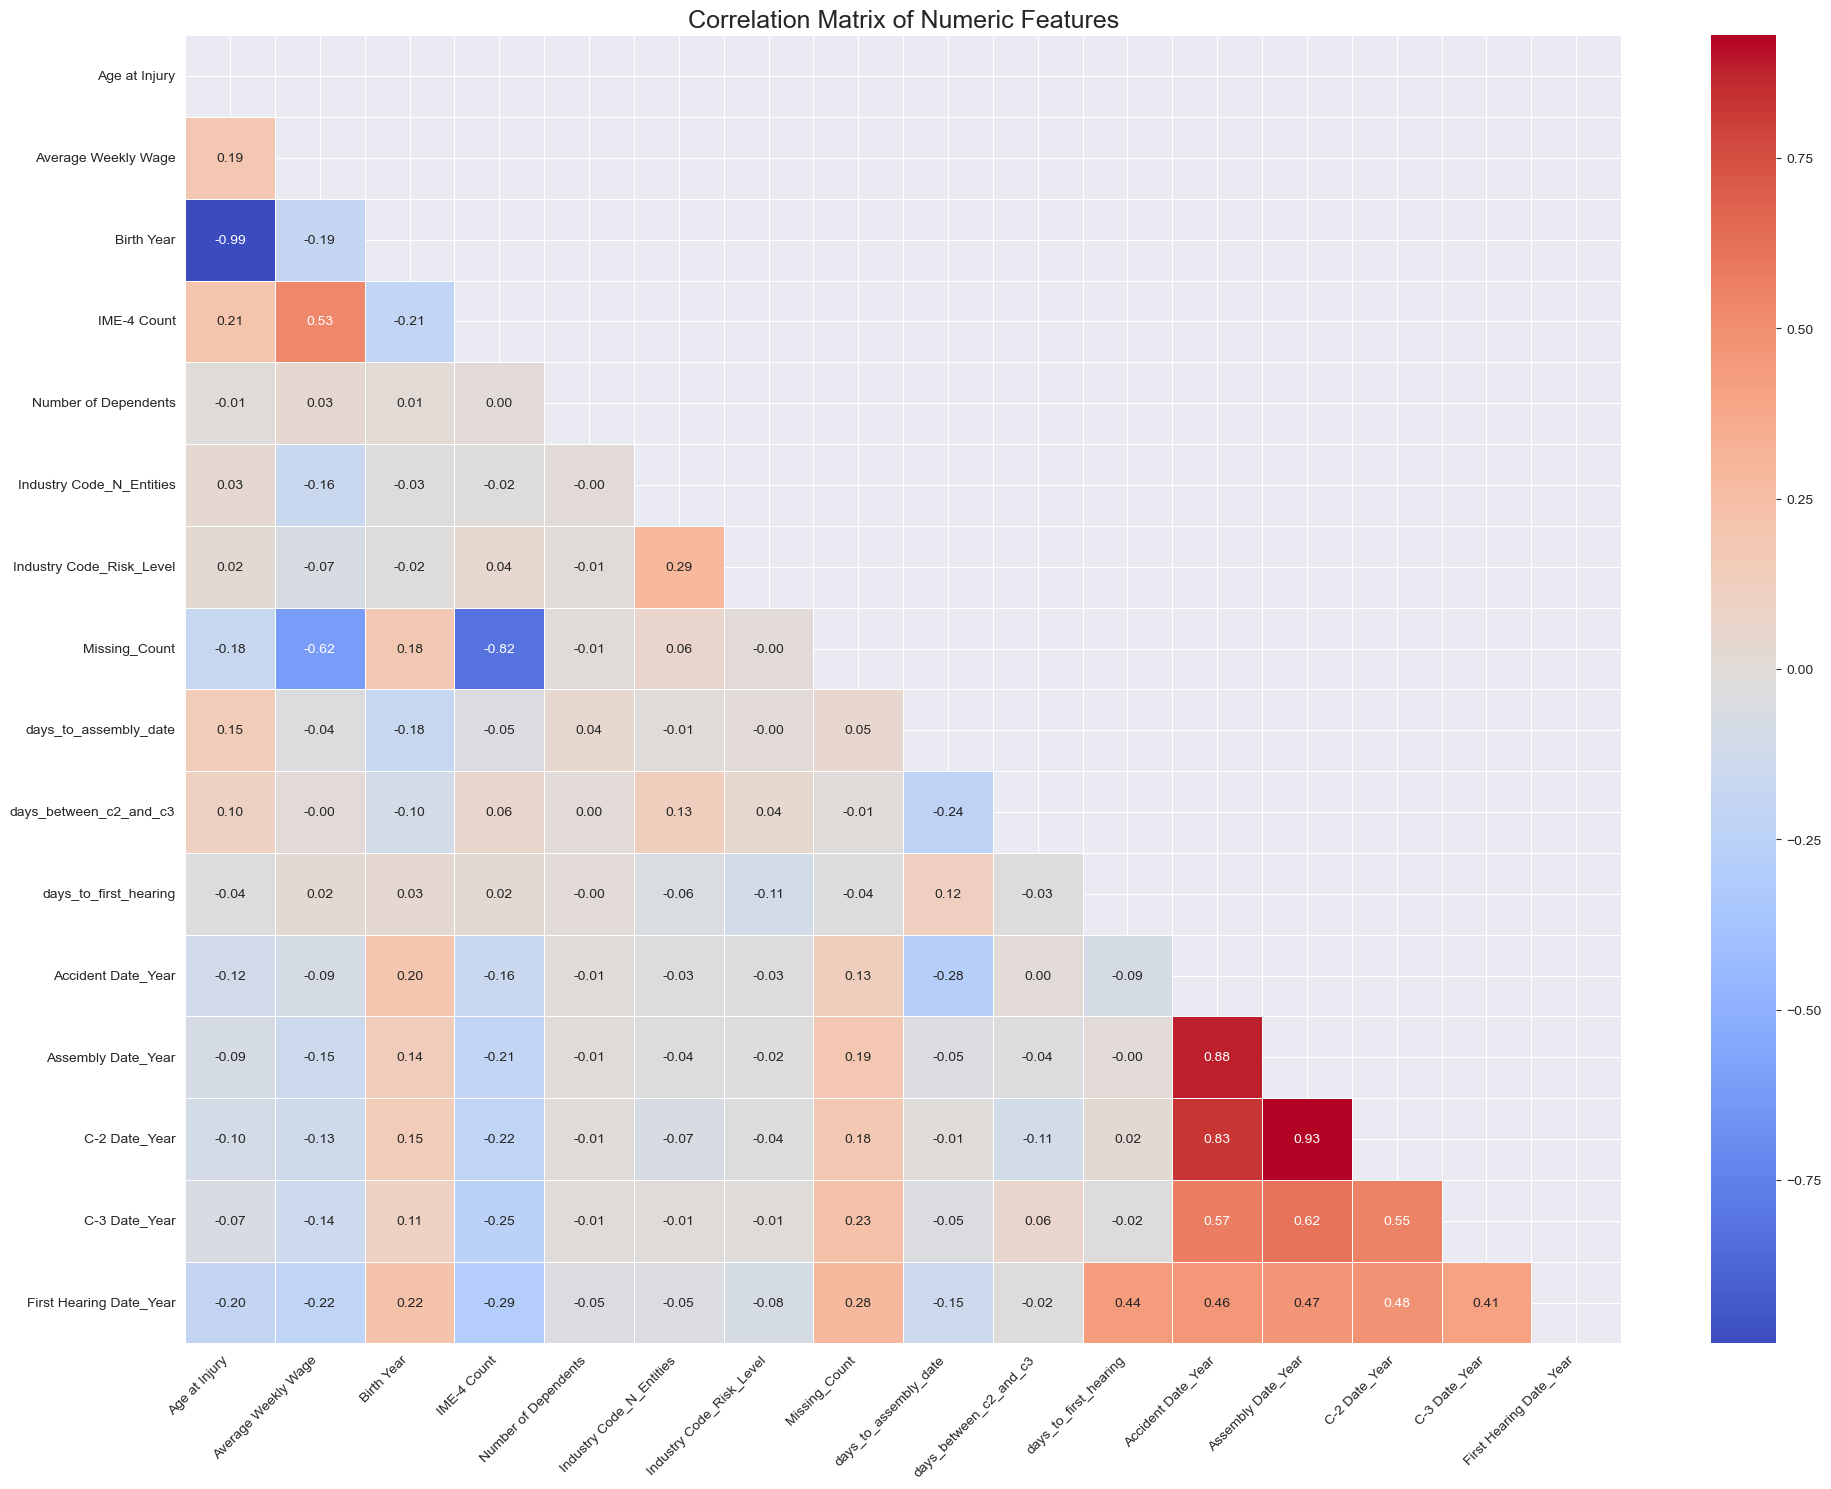

[('Age at Injury', 'Birth Year', 0.99), ('IME-4 Count', 'Missing_Count', 0.82), ('Accident Date_Year', 'Assembly Date_Year', 0.88), ('Accident Date_Year', 'C-2 Date_Year', 0.83), ('Assembly Date_Year', 'C-2 Date_Year', 0.93)]


In [33]:
# Calculate correlation matrix for numeric features only
correlation_matrix = X_train_resampled[numerical_col].corr(method='spearman').round(2)

# Step 3: Mask the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Step 4: Plot the heatmap with improved x-axis formatting
plt.figure(figsize=(20, 15))  # Adjust figure size
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5
)

# Rotate x-axis labels to avoid overlap
plt.xticks(fontsize=10, rotation=45, ha='right')  # Rotate for better readability
plt.yticks(fontsize=10)  # Adjust y-axis font size
plt.title("Correlation Matrix of Numeric Features", fontsize=18)
plt.tight_layout()  # Adjust layout to fit everything cleanly
plt.show()

# Getting the higher correlated pairs of features
abs_corr_matrix = correlation_matrix.abs()

# Identify pairs with high correlation, avoiding duplicates by only considering the upper triangular matrix
threshold = 0.7
high_corr_pairs = [
    (feature_1, feature_2, abs_corr_matrix.loc[feature_1, feature_2])
    for i, feature_1 in enumerate(abs_corr_matrix.columns)
    for j, feature_2 in enumerate(abs_corr_matrix.columns)
    if i < j and abs_corr_matrix.loc[feature_1, feature_2] > threshold
]

print(high_corr_pairs)

There are some highly correlated features in the dataset. We will consider removing some in order to avoid multicollinearity.

* G test for categorical features

In [34]:
def G_test(X,y,var):
    dfObserved = pd.crosstab(y,X)
    g_stat, p, dof, expected = chi2_contingency(dfObserved.values, lambda_="log-likelihood")
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    return (g_stat, p)

th = 0
a = 0.05
for var in categorical_col:
    g_stat, p = G_test(X_train_resampled[var], y_train_resampled, var)
    th += g_stat
    if p<a:
        print("{0} is IMPORTANT for Prediction".format(var))
    else:
        print("{0} is NOT an important predictor. (Discard {0} from model)".format(var))

Alternative Dispute Resolution is IMPORTANT for Prediction
Attorney/Representative is IMPORTANT for Prediction
Carrier Type is IMPORTANT for Prediction
County of Injury is IMPORTANT for Prediction
COVID-19 Indicator is IMPORTANT for Prediction
District Name is IMPORTANT for Prediction
Gender is IMPORTANT for Prediction
Industry Code is IMPORTANT for Prediction
Medical Fee Region is IMPORTANT for Prediction
WCIO Cause of Injury Code is IMPORTANT for Prediction
WCIO Nature of Injury Code is IMPORTANT for Prediction
WCIO Part Of Body Code is IMPORTANT for Prediction
Agreement Reached is IMPORTANT for Prediction
WCIO Cause of Injury Code_Group is IMPORTANT for Prediction
WCIO Nature of Injury Code_Group is IMPORTANT for Prediction
WCIO Part Of Body Code_Group is IMPORTANT for Prediction
Under Age is IMPORTANT for Prediction
Age_is_null is IMPORTANT for Prediction
had_a_hearing is IMPORTANT for Prediction
has_IME_4_Count is IMPORTANT for Prediction
Average Weekly Wage_is_null is IMPORTANT f

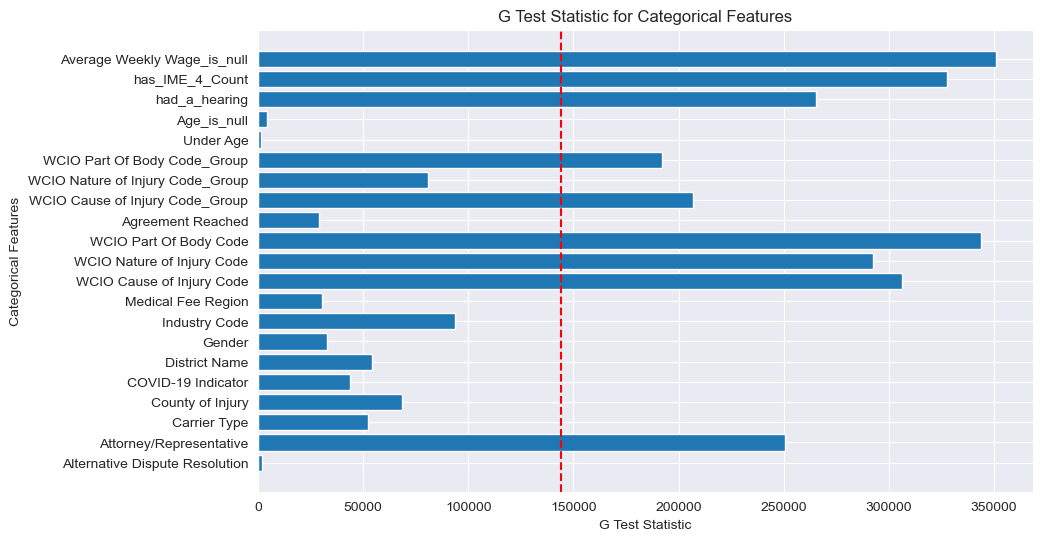

Attorney/Representative was chosen for prediction
WCIO Cause of Injury Code was chosen for prediction
WCIO Nature of Injury Code was chosen for prediction
WCIO Part Of Body Code was chosen for prediction
WCIO Cause of Injury Code_Group was chosen for prediction
WCIO Part Of Body Code_Group was chosen for prediction
had_a_hearing was chosen for prediction
has_IME_4_Count was chosen for prediction
Average Weekly Wage_is_null was chosen for prediction


In [35]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(categorical_col, [G_test(X_train_resampled[var], y_train_resampled, var)[0] for var in categorical_col])
plt.xlabel("G Test Statistic")
plt.ylabel("Categorical Features")
plt.title("G Test Statistic for Categorical Features")
# add a vertical line with the threshold
plt.axvline(x=th/len(categorical_col), color='r', linestyle='--')
plt.show()

# Choosing the best features
for var in categorical_col:
    if G_test(X_train_resampled[var], y_train_resampled, var)[0] >= th/len(categorical_col):
        print(f"{var} was chosen for prediction")
    continue

* Cramér's V for categorical features

In [36]:
def CramerV(X,y,var):
    dfObserved = pd.crosstab(y,X)
    chi2, p, dof, expected = chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)

    # Cramer's V calculation

    # Compute the number of observations
    n = dfObserved.sum().sum()

    # Find the smaller dimension of the table (rows or columns)
    k = min(dfObserved.shape)

    # Comp ute Cramér's V
    V = np.sqrt(chi2 / (n * (k - 1)))

    return V

for var in categorical_col:
    print(f"Cramer's V for {var}: {CramerV(X_train_resampled[var], y_train_resampled, var):.4f}")

Cramer's V for Alternative Dispute Resolution: 0.0920
Cramer's V for Attorney/Representative: 0.7347
Cramer's V for Carrier Type: 0.1818
Cramer's V for County of Injury: 0.1573
Cramer's V for COVID-19 Indicator: 0.3905
Cramer's V for District Name: 0.1396
Cramer's V for Gender: 0.1935
Cramer's V for Industry Code: 0.1859
Cramer's V for Medical Fee Region: 0.1565
Cramer's V for WCIO Cause of Injury Code: 0.3726
Cramer's V for WCIO Nature of Injury Code: 0.3552
Cramer's V for WCIO Part Of Body Code: 0.3886
Cramer's V for Agreement Reached: 0.3346
Cramer's V for WCIO Cause of Injury Code_Group: 0.2943
Cramer's V for WCIO Nature of Injury Code_Group: 0.3795
Cramer's V for WCIO Part Of Body Code_Group: 0.3034
Cramer's V for Under Age: 0.0594
Cramer's V for Age_is_null: 0.1327
Cramer's V for had_a_hearing: 0.7355
Cramer's V for has_IME_4_Count: 0.8181
Cramer's V for Average Weekly Wage_is_null: 0.8621


The threshold for choosing the best features is the average of the Cramér's V scores.

In [37]:
for var in categorical_col:
    if CramerV(X_train_resampled[var], y_train_resampled, var) >= 0.3:
        print(f"{var} was chosen for prediction")
    continue

Attorney/Representative was chosen for prediction
COVID-19 Indicator was chosen for prediction
WCIO Cause of Injury Code was chosen for prediction
WCIO Nature of Injury Code was chosen for prediction
WCIO Part Of Body Code was chosen for prediction
Agreement Reached was chosen for prediction
WCIO Nature of Injury Code_Group was chosen for prediction
WCIO Part Of Body Code_Group was chosen for prediction
had_a_hearing was chosen for prediction
has_IME_4_Count was chosen for prediction
Average Weekly Wage_is_null was chosen for prediction


* Visualizing the relationship between categorical features and the target variable

#### Wrapper methods

* Recursive Feature Elimination (RFE) with LightGBM

In [43]:
#no of features
nof_list=np.arange(1, len(numerical_col) + 1)
high_score=0
#Variable to store the optimum features
nof=1
macrof1_train_score_list =[]
macrof1_val_score_list = []

for n in range(len(nof_list)):
    model = LGBMClassifier(n_jobs=-1, random_state=42)

    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_resampled[numerical_col],y_train_resampled)
    X_val_rfe = rfe.transform(X_val[numerical_col])
    model.fit(X_train_rfe,y_train_resampled)

    #predictions
    y_train_pred = model.predict(X_train_rfe)
    y_val_pred = model.predict(X_val_rfe)

    #storing results on training data
    train_score = f1_score(y_train_resampled,y_train_pred,average='macro')
    macrof1_train_score_list.append(train_score)

    #storing results on training data
    val_score = f1_score(y_val,y_val_pred,average='macro')
    macrof1_val_score_list.append(val_score)

    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4079
[LightGBM] [Info] Number of data points in the train set: 383176, number of used features: 16
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

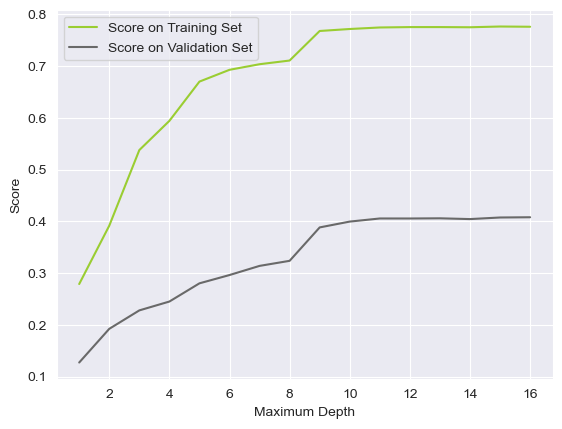

Validation f1 macro score increase per feature:

 For the first 9 features: 0.029023008674608705
 After 9 features: 0.0011981177083396316


In [44]:
plt.plot(list(range(1,len(numerical_col) + 1)), macrof1_train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1, len(numerical_col) + 1)), macrof1_val_score_list, label="Score on Validation Set", color='dimgray')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

print("Validation f1 macro score increase per feature:")
print(f"\n For the first 9 features: {(np.array(macrof1_val_score_list[:9]).max() - np.array(macrof1_val_score_list[:9]).min())/9}")
print(f" After 9 features: {(np.array(macrof1_val_score_list[9:]).max() - np.array(macrof1_val_score_list[9:]).min())/7}")

Let's consider RFE with 9 Features. There is no significant improvement in the model performance when considering more than 9 features.

In [46]:
model = LGBMClassifier(n_jobs=-1, random_state=42)

rfe = RFE(estimator = model, n_features_to_select = 9)
X_train_rfe = rfe.fit_transform(X_train_resampled[numerical_col],y_train_resampled)
model.fit(X_train_rfe,y_train_resampled)

print(pd.Series(rfe.support_, index = numerical_col))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4079
[LightGBM] [Info] Number of data points in the train set: 383176, number of used features: 16
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

* Recursive Feature Elimination (RFE) with Logistic Regression

In the Light GBM method we removed 7 features, so we will use that to make the "n_features_to_select" search in Logistic Regression computationally more efficient. The search will be performed with only 9 iterations, assuming a simpler model like Logistic regression would eliminate more features than a more complex model like Light GBM, because a Logistic Regression won't be able to capture more complex non-linear relationships.

In [47]:
nof_list = np.arange(1, 10)  # Adjusted to not exceed the available features
high_score = 0
nof = 1  # Initialize to the minimum features
macrof1_train_score_list = []
macrof1_val_score_list = []

np.random.seed(15)

for n in range(len(nof_list)):
    print(f"Iteration: {nof_list[n]} features")
    model = LogisticRegression(n_jobs=-1, max_iter=200, random_state=42)

    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_resampled[numerical_col], y_train_resampled)
    X_val_rfe = rfe.transform(X_val[numerical_col])
    model.fit(X_train_rfe, y_train_resampled)

    # Predictions
    y_train_pred = model.predict(X_train_rfe)
    y_val_pred = model.predict(X_val_rfe)

    # Storing results on training data
    train_score = f1_score(y_train_resampled, y_train_pred, average='macro')
    macrof1_train_score_list.append(train_score)

    # Storing results on validation data
    val_score = f1_score(y_val, y_val_pred, average='macro')
    macrof1_val_score_list.append(val_score)

    # Check best score
    if val_score >= high_score:
        high_score = val_score
        nof = nof_list[n]

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))


Iteration: 1 features
Iteration: 2 features
Iteration: 3 features
Iteration: 4 features
Iteration: 5 features
Iteration: 6 features
Iteration: 7 features
Iteration: 8 features
Iteration: 9 features
Optimum number of features: 9
Score with 9 features: 0.288013


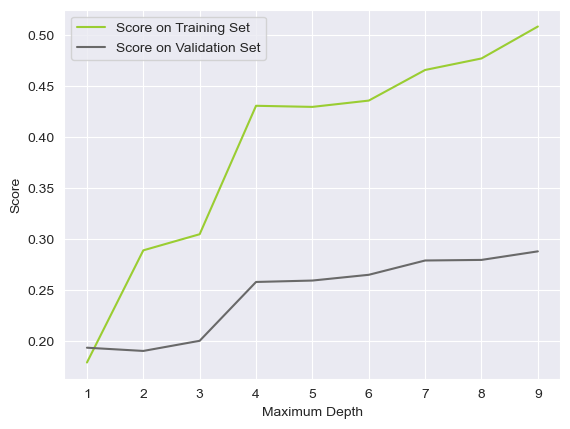

Validation f1 macro score increase per feature:

 For the first 4 features: 0.016877258307171746
 After 4 features: 0.004762458993823169


In [48]:
plt.plot(list(range(1,10)), macrof1_train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,10)), macrof1_val_score_list, label="Score on Validation Set", color='dimgray')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

print("Validation f1 macro score increase per feature:")
print(f"\n For the first 4 features: {(np.array(macrof1_val_score_list[:4]).max() - np.array(macrof1_val_score_list[:4]).min())/4}")
print(f" After 4 features: {(np.array(macrof1_val_score_list[4:]).max() - np.array(macrof1_val_score_list[4:]).min())/6}")

Let's consider RFE with 4 features.

In [49]:
model = LogisticRegression(n_jobs=-1, random_state=42)

rfe = RFE(estimator = model, n_features_to_select = 4)
X_train_rfe = rfe.fit_transform(X_train_resampled[numerical_col],y_train_resampled)
model.fit(X_train_rfe,y_train_resampled)

print(pd.Series(rfe.support_, index = numerical_col))

Age at Injury               False
Average Weekly Wage          True
Birth Year                  False
IME-4 Count                 False
Number of Dependents        False
Industry Code_N_Entities    False
Industry Code_Risk_Level    False
Missing_Count                True
days_to_assembly_date       False
days_between_c2_and_c3      False
days_to_first_hearing       False
Accident Date_Year          False
Assembly Date_Year           True
C-2 Date_Year                True
C-3 Date_Year               False
First Hearing Date_Year     False
dtype: bool


#### Embedded methods

* Lasso Regression for numerical features

In [50]:
# Create a LassoCV model to exclude features with coefficients close to 0
reg = LassoCV()
reg.fit(X_train_resampled[numerical_col], y_train_resampled)

coef = pd.Series(reg.coef_, index = numerical_col, name='Coefficient')
coef.sort_values(ascending=False)

Age at Injury               0.585277
IME-4 Count                 0.094129
Average Weekly Wage         0.034948
days_to_first_hearing       0.000683
Birth Year                 -0.000000
Number of Dependents        0.000000
Industry Code_N_Entities   -0.000000
Industry Code_Risk_Level    0.000000
Accident Date_Year         -0.000000
Assembly Date_Year         -0.000000
C-2 Date_Year              -0.000000
C-3 Date_Year               0.000000
days_between_c2_and_c3     -0.000094
days_to_assembly_date      -0.002125
First Hearing Date_Year    -0.704481
Missing_Count              -0.704902
Name: Coefficient, dtype: float64

In [51]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 8 variables and eliminated the other 8 variables


We can consider eliminating 'Average Weekly Wage' because it has a coefficient close to 0, although it was chosen as significant by the Lasso Regression.

* CatBoost feature importance for categorical features

0:	learn: 1.8161067	total: 4.08s	remaining: 16m 54s
1:	learn: 1.6609980	total: 8.51s	remaining: 17m 35s
2:	learn: 1.5304933	total: 12.1s	remaining: 16m 36s
3:	learn: 1.4297159	total: 15.5s	remaining: 15m 52s
4:	learn: 1.3533249	total: 19.1s	remaining: 15m 37s
5:	learn: 1.2885195	total: 23.3s	remaining: 15m 46s
6:	learn: 1.2339470	total: 27.3s	remaining: 15m 46s
7:	learn: 1.1864411	total: 30.8s	remaining: 15m 32s
8:	learn: 1.1410760	total: 35s	remaining: 15m 37s
9:	learn: 1.1014849	total: 39.1s	remaining: 15m 38s
10:	learn: 1.0667994	total: 42.4s	remaining: 15m 21s
11:	learn: 1.0333153	total: 46.1s	remaining: 15m 13s
12:	learn: 1.0033957	total: 50.6s	remaining: 15m 22s
13:	learn: 0.9750644	total: 54.5s	remaining: 15m 18s
14:	learn: 0.9515131	total: 58.6s	remaining: 15m 17s
15:	learn: 0.9298987	total: 1m 2s	remaining: 15m 13s
16:	learn: 0.9115212	total: 1m 6s	remaining: 15m 7s
17:	learn: 0.8919323	total: 1m 9s	remaining: 14m 56s
18:	learn: 0.8771621	total: 1m 13s	remaining: 14m 52s
19:	l

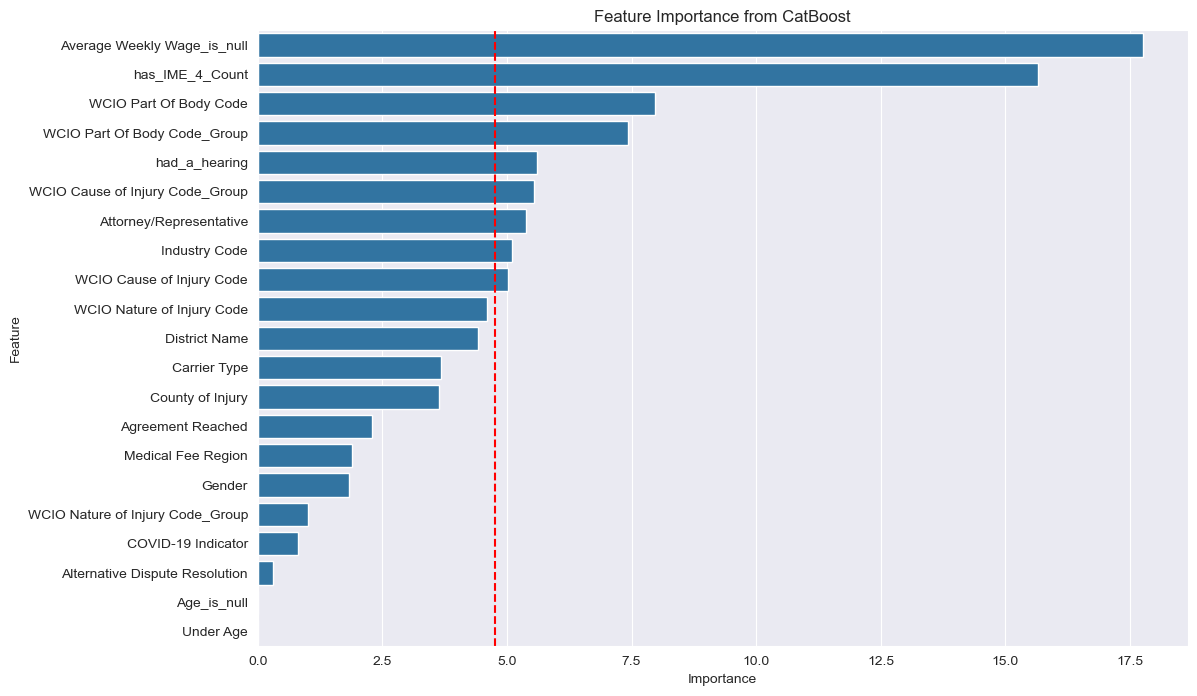

Selected Features and their importance:


,Feature,Importance
20,Average Weekly Wage_is_null,17.767247
19,has_IME_4_Count,15.661626
11,WCIO Part Of Body Code,7.973078
15,WCIO Part Of Body Code_Group,7.426790
18,had_a_hearing,5.603737
13,WCIO Cause of Injury Code_Group,5.551353
1,Attorney/Representative,5.388183
7,Industry Code,5.110675
9,WCIO Cause of Injury Code,5.016443


In [62]:
# Uniformizing categorical features format in order for CatBoost to choose encodings based on cardinality
X_train_resampled[categorical_col] = X_train_resampled[categorical_col].astype(str)

# Create a CatBoost classifier
catboost = CatBoostClassifier(
    cat_features=categorical_col,
    random_state=42,
    iterations=250,
    learning_rate=0.1
)

catboost.fit(X_train_resampled[categorical_col], y_train_resampled)

# 1. Get Feature Importance
fi = catboost.get_feature_importance(type='FeatureImportance')

# 2. Create a DataFrame for better visualization
fi_df = pd.DataFrame({
    'Feature': categorical_col,
    'Importance': fi
})

#Calculate the Average Contribution of Each Categorical Feature
avg_contribution = fi_df['Importance'].mean()

# Sort by Importance
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# 3. Plot the Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.axvline(x=avg_contribution, color='r', linestyle='--')
plt.title('Feature Importance from CatBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Show selected features (features with importance above the average)
selected_features = fi_df[fi_df['Importance'] > avg_contribution]
print("Selected Features and their importance:")
selected_features

* Reverting dataset to its original format

In [52]:
X_train_resampled[categorical_col] = X_train_resampled[categorical_col].astype(float)

### Selecting the best features

In [53]:
best_features = ["Age at Injury", "Attorney/Representative", "Average Weekly Wage", "WCIO Cause of Injury Code", "WCIO Nature of Injury Code", "WCIO Part Of Body Code", "WCIO Cause of Injury Code_Group", "WCIO Part Of Body Code_Group", "Missing_Count", "had_a_hearing", "has_IME_4_Count", "Average Weekly Wage_is_null"]

X_train_OE = X_train_resampled[best_features + ["Agreement Reached"]]
X_val_OE = X_val[best_features + ["Agreement Reached"]]

X_train_fs = X_train.copy()
X_val_fs = X_val.copy()

numerical_col_a = numerical_col.copy()
categorical_col_a = categorical_col.copy()

for df in [X_train_resampled, X_train, X_val]:
    df.drop(columns=[col for col in df.columns if col not in best_features], inplace=True)

categorical_col = [col for col in categorical_col if col in best_features]
numerical_col = [col for col in numerical_col if col in best_features]
low_cardinality = ['Attorney/Representative', 'had_a_hearing', 'has_IME_4_Count', 'Average Weekly Wage_is_null']

print(f"The best features are: {best_features}")

The best features are: ['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'WCIO Cause of Injury Code_Group', 'WCIO Part Of Body Code_Group', 'Missing_Count', 'had_a_hearing', 'has_IME_4_Count', 'Average Weekly Wage_is_null']


# Modelling

* Quick evaluation metrics table to view the result of various approaches

In [54]:
def performance_table(xtrain, ytrain, xval, yval, models, ohc = False):

    if ohc:
        xtrain = pd.concat([xtrain[numerical_col], xtrain[low_cardinality]], axis=1)
        xval = pd.concat([xval[numerical_col], xval[low_cardinality]], axis=1)

    # Train and Evaluate Models
    results = []
    for name, model in models.items():
        print(f"Training and evaluating {name}...")
        # Train the model
        model.fit(xtrain, ytrain)

        # Predict class labels on validation set
        ypred = model.predict(xval)

        # Calculate probabilities or decision function for AUC
        if hasattr(model, "predict_proba"):  # Some models, like Random Forest, have predict_proba
            y_train_pred_prob = model.predict_proba(xtrain)
            y_val_pred_prob = model.predict_proba(xval)
        else:
            # LinearSVC uses decision_function, which we can apply sigmoid to for probabilities
            y_train_pred_prob = expit(model.decision_function(xtrain))  # Sigmoid of decision function
            y_val_pred_prob = expit(model.decision_function(xval))  # Sigmoid of decision function

        # For multi-class, we need to binarize the labels for AUC calculation
        y_train_bin = label_binarize(ytrain, classes=np.unique(ytrain))
        y_val_bin = label_binarize(yval, classes=np.unique(yval))

        # Compute AUC scores
        auc_train = roc_auc_score(y_train_bin, y_train_pred_prob, multi_class='ovr')
        auc_val = roc_auc_score(y_val_bin, y_val_pred_prob, multi_class='ovr')

        # Calculate other metrics
        f1 = f1_score(yval, ypred, average='macro')
        accuracy = accuracy_score(yval, ypred)
        precision = precision_score(yval, ypred, average="macro")
        recall = recall_score(yval, ypred, average="macro")

        # Append results
        results.append({
            "Model": name,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Accuracy": accuracy,
            "Overfitting": auc_train - auc_val
        })

    # Create a DataFrame for comparison
    results_df = pd.DataFrame(results)
    results_df = results_df.style.hide(axis="index")
    return results_df

## Results on original data

In [55]:
# Define Models
models1 = {
    "Logistic Regression": LogisticRegression(random_state=42, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', n_jobs=-1),
    "SVC": LinearSVC(random_state=42)
}

models2 = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gaussian Naive Bayes Classifier": GaussianNB()
}

In [56]:
performance_table(X_train, y_train, X_val, y_val, models1, ohc=True)

Training and evaluating Logistic Regression...


C:\Users\afons\miniconda3\envs\DM2425\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training and evaluating KNN...


C:\Users\afons\miniconda3\envs\DM2425\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training and evaluating SVC...


C:\Users\afons\miniconda3\envs\DM2425\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model,Precision,Recall,F1-Score,Accuracy,Overfitting
Logistic Regression,0.370123,0.288224,0.290527,0.752582,-0.000879
KNN,0.354090,0.311122,0.316666,0.725795,0.188652
SVC,0.298214,0.253667,0.230777,0.739570,0.000518


In [57]:
performance_table(X_train, y_train, X_val, y_val, models2)

Training and evaluating Decision Tree...
Training and evaluating Gaussian Naive Bayes Classifier...


Model,Precision,Recall,F1-Score,Accuracy,Overfitting
Decision Tree,0.346121,0.343752,0.344656,0.687448,0.335997
Gaussian Naive Bayes Classifier,0.339141,0.484360,0.263195,0.553067,-0.001405


It looks like trees are the best approach, even though they tend to overfit a little

## Addressing class imbalance

### Using Ensembles

In [58]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

In [59]:
performance_table(X_train, y_train, X_val, y_val, models)

Training and evaluating Random Forest...
Training and evaluating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 398251, number of used features: 12
[LightGBM] [Info] Start training from score -3.922374
[LightGBM] [Info] Start training from score -0.677425
[LightGBM] [Info] Start training from score -2.118030
[LightGBM] [Info] Start training from score -1.346854
[LightGBM] [Info] Start training from score -2.481825
[LightGBM] [Info] Start training from score -4.909353
[LightGBM] [Info] Start training from score -8.705183
[LightGBM] [Info] Start training from score -7.101824
Training and evaluating AdaBoost...


C:\Users\afons\miniconda3\envs\DM2425\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model,Precision,Recall,F1-Score,Accuracy,Overfitting
Random Forest,0.422857,0.350467,0.366316,0.746050,0.169172
LightGBM,0.420790,0.351465,0.347240,0.768056,0.023386
AdaBoost,0.309447,0.330566,0.161141,0.206663,0.001948


Using ensembles improves our results so we will try to use them in combination with other imbalanced learning techniques

### Resampling

#### Hybrid resampling used in feature selection

* Oversampling with SMOTENC and then under-sampling with RandomUnderSampler

This is the same resampling technique we did before feature selection so there is no need to repeat the same process. The results of the technique are shown below. We will also save the resampled data, as it can not be replicated at this point in time, because of the features already eliminated.

In [60]:
performance_table(X_train_resampled, y_train_resampled, X_val, y_val, models)

Training and evaluating Random Forest...
Training and evaluating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 977
[LightGBM] [Info] Number of data points in the train set: 383176, number of used features: 12
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
Training and evaluating AdaBoost...


C:\Users\afons\miniconda3\envs\DM2425\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model,Precision,Recall,F1-Score,Accuracy,Overfitting
Random Forest,0.352473,0.493344,0.376876,0.606941,0.115823
LightGBM,0.383455,0.533994,0.412904,0.714323,0.055187
AdaBoost,0.245993,0.452094,0.126770,0.109920,0.100112


In [61]:
X_train_resampled_hr = X_train_resampled.copy()
y_train_resampled_hr = y_train_resampled.copy()

#### Oversampling

* Oversampling with SMOTENC

In [62]:
# Assume X_train is your feature matrix, and the first two columns are categorical (label-encoded)
categorical_features = [X_train.columns.get_loc(col) for col in categorical_col if col in X_train.columns]  # Indices of categorical columns

smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42, n_jobs=-1)

# Apply SMOTE to generate synthetic samples
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

C:\Users\afons\miniconda3\envs\DM2425\Lib\site-packages\imblearn\over_sampling\_smote\base.py:645: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [63]:
performance_table(X_train_resampled, y_train_resampled, X_val, y_val, models)

Training and evaluating Random Forest...
Training and evaluating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 1618248, number of used features: 12
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
Training and evaluating AdaBoost...


C:\Users\afons\miniconda3\envs\DM2425\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model,Precision,Recall,F1-Score,Accuracy,Overfitting
Random Forest,0.368808,0.441854,0.392823,0.681800,0.146421
LightGBM,0.385456,0.535879,0.396766,0.716720,0.055010
AdaBoost,0.263136,0.462203,0.136594,0.147112,0.098060


#### Under Sampling

* Under sampling with Random Undersampler

In [64]:
# Under-sampling with RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train, )

In [65]:
performance_table(X_train_resampled, y_train_resampled, X_val, y_val, models)

Training and evaluating Random Forest...
Training and evaluating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 528, number of used features: 12
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

C:\Users\afons\miniconda3\envs\DM2425\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\afons\miniconda3\envs\DM2425\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model,Precision,Recall,F1-Score,Accuracy,Overfitting
Random Forest,0.315669,0.525089,0.299237,0.576913,0.127092
LightGBM,0.304859,0.511338,0.288135,0.521822,0.142209
AdaBoost,0.040535,0.319543,0.024037,0.029125,0.012597


### Changing model weights

In [66]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "LightGBM": LGBMClassifier(random_state=42, is_unbalance=True),  # Alternatively, use scale_pos_weight
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
        random_state=42
    )
}

In [67]:
performance_table(X_train, y_train, X_val, y_val, models)

Training and evaluating Random Forest...


C:\Users\afons\miniconda3\envs\DM2425\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training and evaluating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 398251, number of used features: 12
[LightGBM] [Info] Start training from score -3.922374
[LightGBM] [Info] Start training from score -0.677425
[LightGBM] [Info] Start training from score -2.118030
[LightGBM] [Info] Start training from score -1.346854
[LightGBM] [Info] Start training from score -2.481825
[LightGBM] [Info] Start training from score -4.909353
[LightGBM] [Info] Start training from score -8.705183
[LightGBM] [Info] Start training from score -7.101824
Training and evaluating AdaBoost...


C:\Users\afons\miniconda3\envs\DM2425\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model,Precision,Recall,F1-Score,Accuracy,Overfitting
Random Forest,0.390798,0.380801,0.374206,0.718184,0.171424
LightGBM,0.420790,0.351465,0.347240,0.768056,0.023386
AdaBoost,0.280144,0.423435,0.098355,0.073530,0.001460


## Best Combination

The best combination is using the same hybrid resampling we used in Feature Selection combined with light GBM boosting ensemble.

In [68]:
models = {
    "LightGBM": LGBMClassifier(random_state=42),
}

In [69]:
performance_table(X_train_resampled_hr, y_train_resampled_hr, X_val, y_val, models)

Training and evaluating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 977
[LightGBM] [Info] Number of data points in the train set: 383176, number of used features: 12
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442


Model,Precision,Recall,F1-Score,Accuracy,Overfitting
LightGBM,0.383455,0.533994,0.412904,0.714323,0.055187


## Open Ended Section - "Predicting Agreement Reached" to enhance model capabilities

### Feature Selection - Agreement Reach

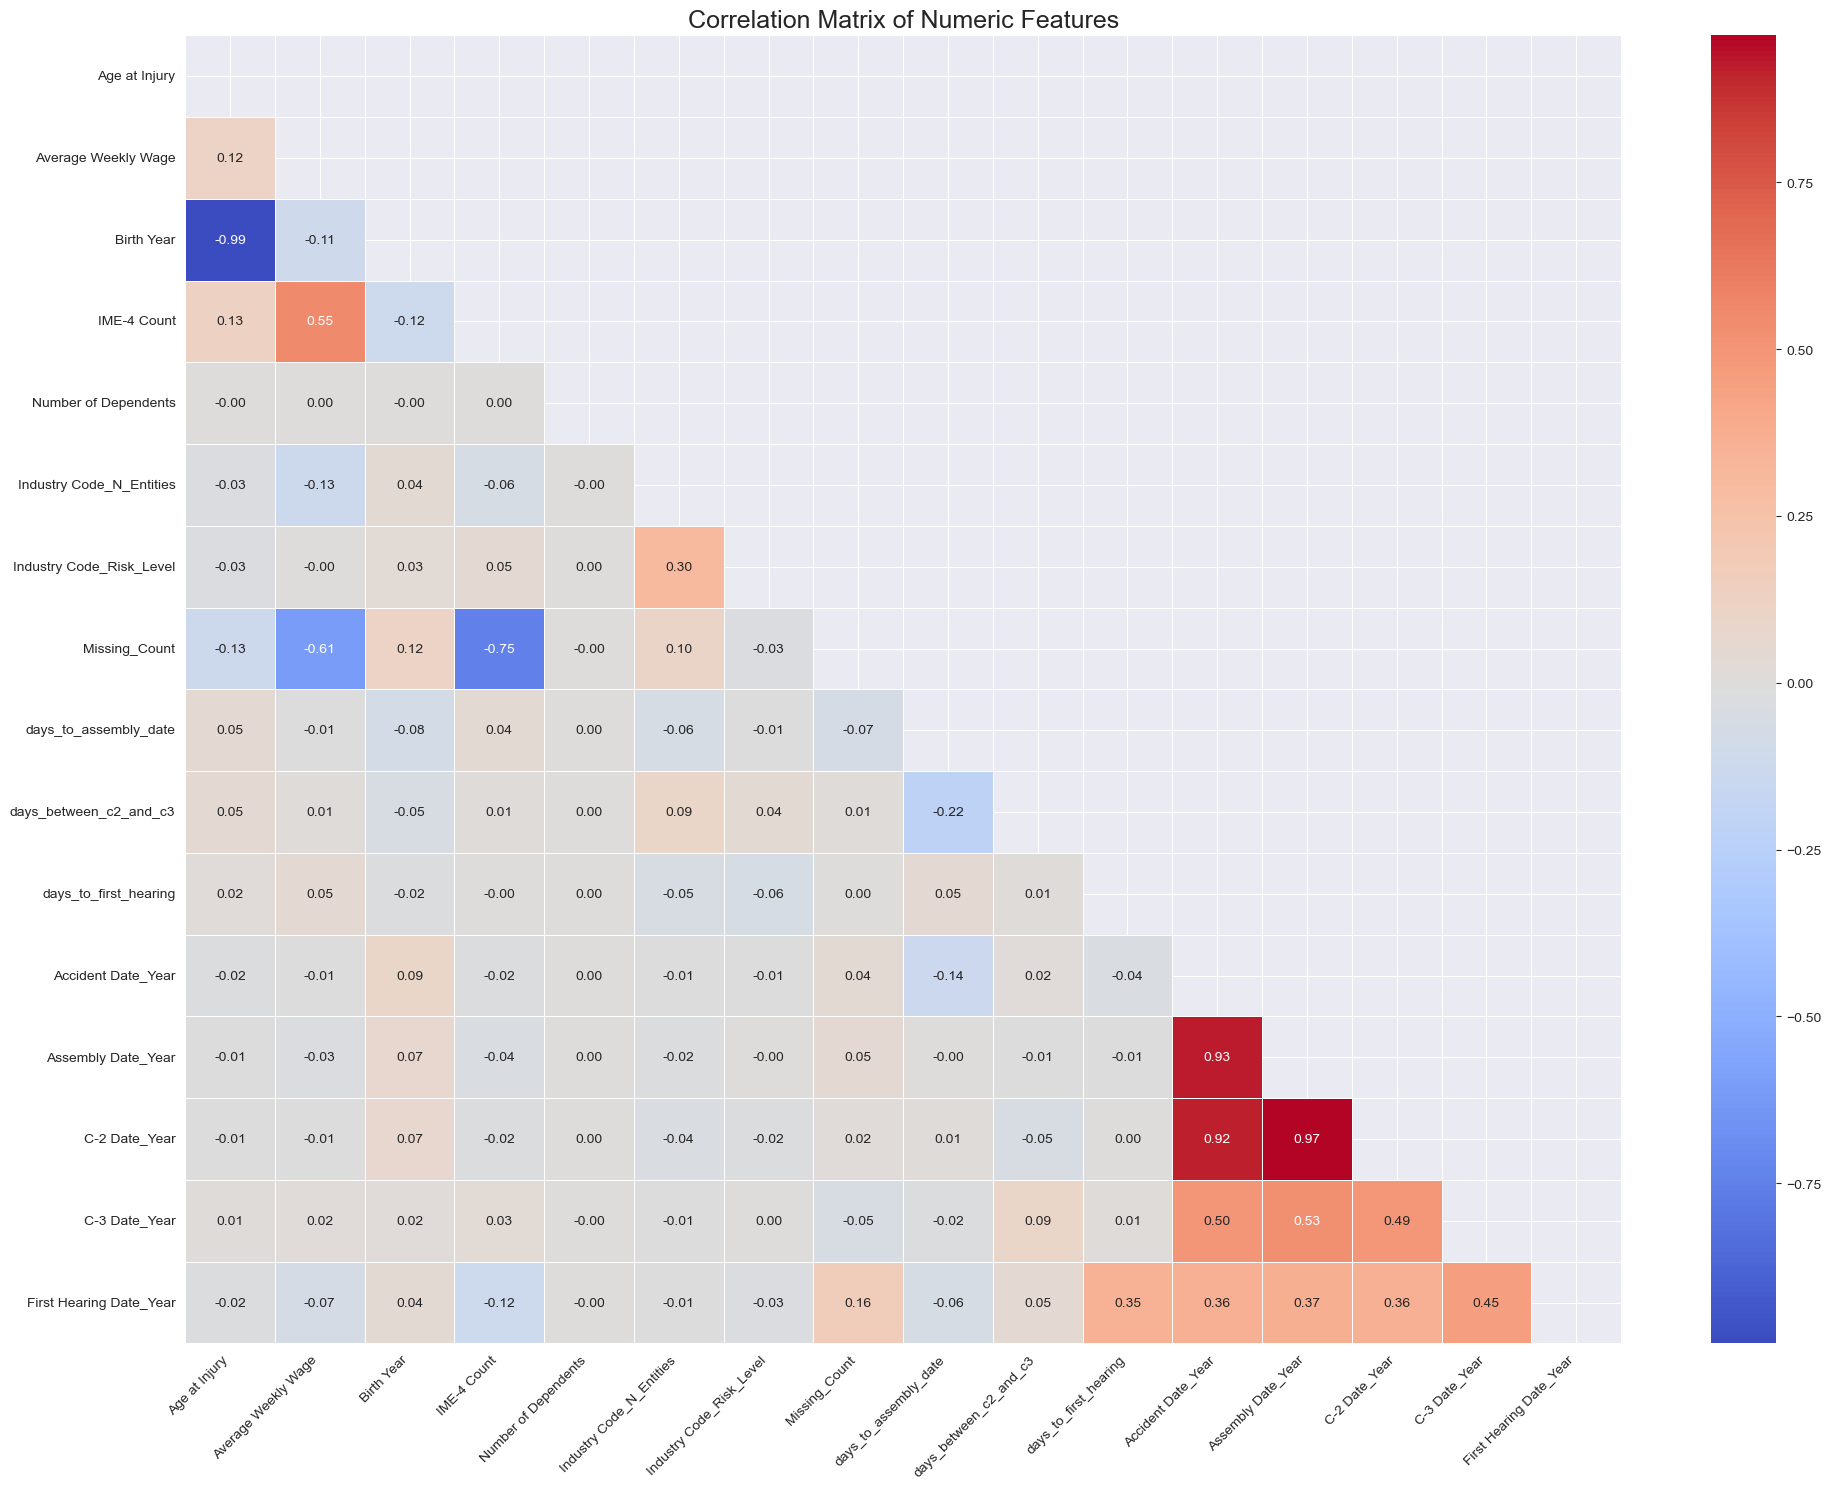

[('Age at Injury', 'Birth Year', 0.99), ('IME-4 Count', 'Missing_Count', 0.75), ('Accident Date_Year', 'Assembly Date_Year', 0.93), ('Accident Date_Year', 'C-2 Date_Year', 0.92), ('Assembly Date_Year', 'C-2 Date_Year', 0.97)]


In [70]:
# Calculate correlation matrix for numeric features only
correlation_matrix = X_train_fs[numerical_col_a].corr(method='spearman').round(2)

# Step 3: Mask the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Step 4: Plot the heatmap with improved x-axis formatting
plt.figure(figsize=(20, 15))  # Adjust figure size
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5
)

# Rotate x-axis labels to avoid overlap
plt.xticks(fontsize=10, rotation=45, ha='right')  # Rotate for better readability
plt.yticks(fontsize=10)  # Adjust y-axis font size
plt.title("Correlation Matrix of Numeric Features", fontsize=18)
plt.tight_layout()  # Adjust layout to fit everything cleanly
plt.show()

# Getting the higher correlated pairs of features
abs_corr_matrix = correlation_matrix.abs()

# Identify pairs with high correlation, avoiding duplicates by only considering the upper triangular matrix
threshold = 0.7
high_corr_pairs = [
    (feature_1, feature_2, abs_corr_matrix.loc[feature_1, feature_2])
    for i, feature_1 in enumerate(abs_corr_matrix.columns)
    for j, feature_2 in enumerate(abs_corr_matrix.columns)
    if i < j and abs_corr_matrix.loc[feature_1, feature_2] > threshold
]

print(high_corr_pairs)

In [71]:
# Select only numerical features
X_train_numerical = X_train_fs[numerical_col_a]
y_train_a = X_train_fs["Agreement Reached"]

# Apply the ANOVA F-test to the numerical features
anova_selector = SelectKBest(score_func=f_classif, k='all')  # 'k=all' to get all feature scores
anova_selected = anova_selector.fit_transform(X_train_numerical, y_train_a)

# Get the F-test scores for each feature
anova_scores = pd.DataFrame(anova_selector.scores_, index=numerical_col_a, columns=["F-Score"])

# Display the sorted F-test scores (features with highest score first)
print(anova_scores.sort_values("F-Score", ascending=False))


                               F-Score
IME-4 Count               21530.834695
Missing_Count             14910.704422
Accident Date_Year        13041.514155
First Hearing Date_Year   11784.704903
days_to_assembly_date     10837.708894
C-2 Date_Year              7269.403929
Industry Code_Risk_Level   3489.966504
Assembly Date_Year         2207.230871
C-3 Date_Year              1537.681594
Birth Year                  851.418270
Industry Code_N_Entities    568.985379
days_between_c2_and_c3      421.262259
days_to_first_hearing       296.542355
Age at Injury               215.741246
Average Weekly Wage          16.967488
Number of Dependents          0.455852


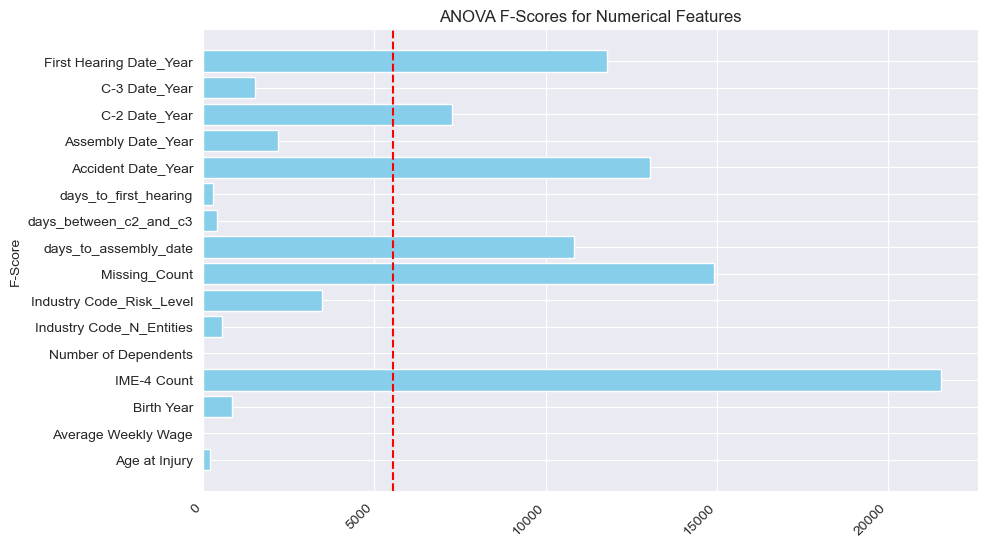

Features with F-Scores above the average ( 5561.32 ):
                              F-Score
IME-4 Count              21530.834695
Missing_Count            14910.704422
days_to_assembly_date    10837.708894
Accident Date_Year       13041.514155
C-2 Date_Year             7269.403929
First Hearing Date_Year  11784.704903


In [72]:
# Calculate the average F-score
average_score = anova_scores["F-Score"].mean()

# Plot the ANOVA F-scores
plt.figure(figsize=(10, 6))
plt.barh(anova_scores.index, anova_scores["F-Score"], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("F-Score")
plt.title("ANOVA F-Scores for Numerical Features")
plt.axvline(x=average_score, color='r', linestyle='--')
plt.show()

# Select features with scores above the average
selected_features = anova_scores[anova_scores["F-Score"] > average_score]

# Display the selected features and their scores
print("Features with F-Scores above the average (", round(average_score, 2), "):")
print(selected_features)

In [73]:
categorical_col_a = [col for col in categorical_col_a if col != 'Agreement Reached']

def G_test(X,y,var):
    dfObserved = pd.crosstab(y,X)
    g_stat, p, dof, expected = chi2_contingency(dfObserved.values, lambda_="log-likelihood")
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    return (g_stat, p)

th = 0
a = 0.05
for var in categorical_col_a:
    g_stat, p = G_test(X_train_fs[var], y_train_a, var)
    th += g_stat
    if p<a:
        print("{0} is IMPORTANT for Prediction".format(var))
    else:
        print("{0} is NOT an important predictor. (Discard {0} from model)".format(var))

Alternative Dispute Resolution is IMPORTANT for Prediction
Attorney/Representative is IMPORTANT for Prediction
Carrier Type is IMPORTANT for Prediction
County of Injury is IMPORTANT for Prediction
COVID-19 Indicator is IMPORTANT for Prediction
District Name is IMPORTANT for Prediction
Gender is IMPORTANT for Prediction
Industry Code is IMPORTANT for Prediction
Medical Fee Region is IMPORTANT for Prediction
WCIO Cause of Injury Code is IMPORTANT for Prediction
WCIO Nature of Injury Code is IMPORTANT for Prediction
WCIO Part Of Body Code is IMPORTANT for Prediction
WCIO Cause of Injury Code_Group is IMPORTANT for Prediction
WCIO Nature of Injury Code_Group is IMPORTANT for Prediction
WCIO Part Of Body Code_Group is IMPORTANT for Prediction
Under Age is IMPORTANT for Prediction
Age_is_null is NOT an important predictor. (Discard Age_is_null from model)
had_a_hearing is IMPORTANT for Prediction
has_IME_4_Count is IMPORTANT for Prediction
Average Weekly Wage_is_null is IMPORTANT for Predict

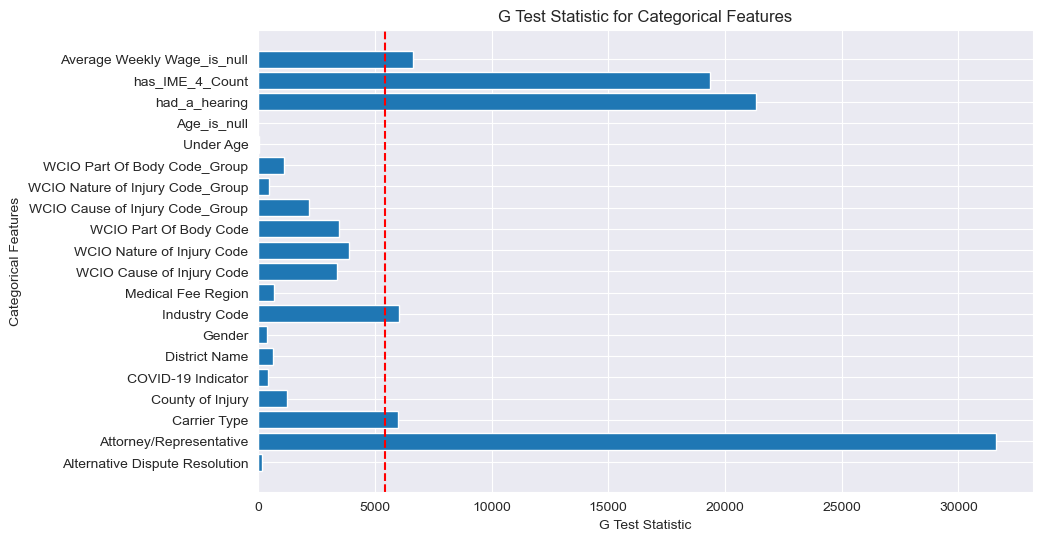

Attorney/Representative was chosen for prediction
Carrier Type was chosen for prediction
Industry Code was chosen for prediction
had_a_hearing was chosen for prediction
has_IME_4_Count was chosen for prediction
Average Weekly Wage_is_null was chosen for prediction


In [74]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(categorical_col_a, [G_test(X_train_fs[var], y_train_a, var)[0] for var in categorical_col_a])
plt.xlabel("G Test Statistic")
plt.ylabel("Categorical Features")
plt.title("G Test Statistic for Categorical Features")
# add a vertical line with the threshold
plt.axvline(x=th/len(categorical_col_a), color='r', linestyle='--')
plt.show()

# Choosing the best features
for var in categorical_col_a:
    if G_test(X_train_fs[var], y_train_a, var)[0] >= th/len(categorical_col_a):
        print(f"{var} was chosen for prediction")
    continue

In [75]:
# Calculate the mutual information between features and target
mutual_info = mutual_info_classif(X_train_fs[categorical_col_a], y_train_a)

# Create a dataframe to display the results
mi_df = pd.DataFrame(mutual_info, index=categorical_col_a, columns=["Mutual Information"])
mi_df = mi_df.sort_values("Mutual Information", ascending=False)

# Select the top N features based on mutual information (adjust N as needed)
top_n_features = mi_df.head(10).index  # Adjust the number as needed

# Filter the selected features
X_train_selected_a = X_train_fs[top_n_features]
print("Selected Features Based on Mutual Information:", top_n_features)


Selected Features Based on Mutual Information: Index(['Average Weekly Wage_is_null', 'WCIO Nature of Injury Code_Group',
       'Attorney/Representative', 'Gender', 'had_a_hearing', 'has_IME_4_Count',
       'Medical Fee Region', 'Carrier Type', 'WCIO Part Of Body Code_Group',
       'WCIO Nature of Injury Code'],
      dtype='object')


In [76]:
# Create a list of selected features (both categorical and numerical)
selected_features_a = ["IME-4 Count", "days_to_assembly_date", "Accident Date_Year",
"First Hearing Date_Year", "Attorney/Representative", "Carrier Type", "had_a_hearing",
"has_IME_4_Count", "Average Weekly Wage_is_null"]

print(selected_features_a)

['IME-4 Count', 'days_to_assembly_date', 'Accident Date_Year', 'First Hearing Date_Year', 'Attorney/Representative', 'Carrier Type', 'had_a_hearing', 'has_IME_4_Count', 'Average Weekly Wage_is_null']


### Model Selection

In [77]:
# Step 1: Prepare the data (X = features, y = target)
Xt = X_train_fs[selected_features_a]  # Features using selected features list
yt = X_train_fs['Agreement Reached']  # Target
Xv = X_val_fs[selected_features_a]    # Validation features using selected features list
yv = X_val_fs['Agreement Reached']   # Validation target

# Step 2: Initialize the models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, n_jobs=-1),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1)
}

# Step 3: Train and evaluate each model
results = {}

for model_name, model in models.items():
    print(f"\nTraining and evaluating {model_name}...")

    # Train the model on the entire resampled dataset
    model.fit(Xt, yt)

    # Make predictions on the validation set (X_val instead of X_test)
    y_val_pred = model.predict(Xv)

    # Calculate performance metrics (e.g., F1 score, Accuracy)
    val_f1 = f1_score(yv, y_val_pred, average='macro')
    val_accuracy = accuracy_score(yv, y_val_pred)

    # Store results
    results[model_name] = {
        "Validation F1 Score": val_f1,
        "Validation Accuracy": val_accuracy
    }

# Step 4: Display results for comparison
print("\nModel Performance Comparison:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"  Validation F1 Score: {metrics['Validation F1 Score']:.4f}")
    print(f"  Validation Accuracy: {metrics['Validation Accuracy']:.4f}")


Training and evaluating Logistic Regression...

Training and evaluating Random Forest...

Training and evaluating XGBoost...

Model Performance Comparison:

Logistic Regression:
  Validation F1 Score: 0.5275
  Validation Accuracy: 0.9542

Random Forest:
  Validation F1 Score: 0.6023
  Validation Accuracy: 0.9474

XGBoost:
  Validation F1 Score: 0.5491
  Validation Accuracy: 0.9555


Random Forest has the best F1 score, so we choose this model.

### Training the model with 'Agreement Reached' and checking the results on the validation set

* Training the model with 'Agreement Reached'

In [78]:
models = {
    "LightGBM": LGBMClassifier(random_state=42),
}

In [79]:
performance_table(X_train_OE, y_train_resampled_hr, X_val_OE, y_val, models)

Training and evaluating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 383176, number of used features: 13
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442


Model,Precision,Recall,F1-Score,Accuracy,Overfitting
LightGBM,0.398260,0.540788,0.427305,0.732369,0.052952


### Predicting 'Agreement Reached' on test dataset

In [80]:
# Step 1: Initialize the Random Forest model
agreement_reached_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Step 2: Train the Random Forest model on the entire resampled training data
agreement_reached_model.fit(Xt, yt)

# Step 3: Select only the relevant features from the test data based on selected_features_a
test_df_selected = test_df[selected_features_a]

# Step 4: Make predictions on the selected features from test_df
predicted_agreement_reached = agreement_reached_model.predict(test_df_selected)

# Step 5: Store predictions in the test_df DataFrame
test_df['Agreement Reached'] = predicted_agreement_reached

# Step 6: Display the first few predictions
print(test_df[['Agreement Reached']].head())

   Agreement Reached
0                0.0
1                0.0
2                0.0
3                0.0
4                0.0


In [81]:
test_df["Agreement Reached"].value_counts()

Agreement Reached
0.0    383232
1.0      2077
Name: count, dtype: int64

## Making prediction on the test dataset

In [83]:
# Map numeric predictions back to original Claim Injury Type labels
injury_type_mapping = {
    2: "2. NON-COMP",
    4: "4. TEMPORARY",
    3: "3. MED ONLY",
    5: "5. PPD SCH LOSS",
    6: "6. PPD NSL",
    1: "1. CANCELLED",
    8: "8. DEATH",
    7: "7. PTD",
}

#creating model
lgbm_model = LGBMClassifier(random_state=42,)

# fitting the model
lgbm_model.fit(X_train_OE, y_train_resampled_hr)

# Predict using the trained XGBoost model
y_pred_test = lgbm_model.predict(test_df[best_features + ["Agreement Reached"]])

# Map the predictions using the injury_type_mapping
y_pred_test = [injury_type_mapping.get(x, x) for x in y_pred_test]

# Create the submission DataFrame
submission = test_df[["Claim Identifier"]].copy()
submission["Claim Injury Type"] = y_pred_test

# Save the submission file
submission.to_csv("submission_file.csv", index=False)

print("Submission file has been created successfully.")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 383176, number of used features: 13
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
Submission file has been created successfully.
